# Running General MCMC Method to Toy Model 
## Excluding entropy-based model

### Imports

In [3]:
import numpy as np
import torch
from numpy import random
from scipy.stats import entropy
from tqdm import tqdm
import time
from proposals import Proposals
from targets import Targets
from kernels import Kernels
import MHstep
import matplotlib.pyplot as plt
import visualisations 
import AC
import statsmodels.api as sm
#from distributions import quadratic_gaussian 
import corner
import pygtc
from scipy.stats import gaussian_kde

torch.set_printoptions(precision=10)

# Custom library
from mcmc import ULA, MALA, GMMALA
from function import MODEL

# For L2HMC
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR

import torch.nn as nn
import itertools
%matplotlib inline

%load_ext autoreload
%autoreload 2
import pdb
# from multiprocessing import Process, Manager
# from multiprocessing import set_start_method

# Test effective sample size
import arviz
import functools
from statsmodels.tsa.stattools import acf as autocorr

c_true, c_contour = 'purple', '0.75'

## This function defines the computation of effective sample size (ESS)

In [4]:
def neff(arr):
    n = len(arr)
    acf = autocorr(arr, nlags=n, fft=True)
    sums = 0
    for k in range(1, len(acf)):
        sums = sums + (n-k)*acf[k]/n

    return n/(1+2*sums)

#np.array([neff(sample0[1][:,j]) for j in range(2)])

# Definition of the toy model and functions

In [5]:
# --- Define a numpy version of your waveform function ---
def h(t, phase, freq, dfreq, ddfreq):
    return torch.sin(phase + freq*t + dfreq*t**2 + ddfreq*t**3)

# --- Define a numpy version of the log likelihood function ---
def log_likelihood(template,observed):
    # Calculate the difference and norm squared, which is the waveform inner product
    difference = observed - template
    norm_squared = np.linalg.norm(difference, axis=-1)**2
    return -0.5 * norm_squared # log likelihood is -0.5<d-h|d-h>

In [6]:
# Global parameters (as in your toy model)
t = torch.arange(0, 100, 0.1) #sampling duration (100) and rate (0.1)
phase_t = torch.arange(-torch.pi, torch.pi, 2*torch.pi/100)
freq_t = torch.arange(0.8, 1.8, 1.0/100)
phase = 0
freq = 1
dfreq = 0.1
ddfreq = 0.001

# Compute the template waveform (using numpy arrays)
template = torch.tensor([h(ti, phase, freq, dfreq, ddfreq) for ti in t])
observed = torch.tensor(np.array([[h(t, phasei, freqi, dfreq, ddfreq) for phasei in phase_t] for freqi in freq_t]))
loglike = log_likelihood(template,observed)

In [7]:
# Define bin edges for histogramming
x_edges = np.linspace(-np.pi, np.pi, 101) # fixed to be 100 bins
y_edges = np.linspace(0.8, 1.8, 101) # fixed to be 100 bins

# Create a reference density (hist_0) for KL divergence calculation.
# For demonstration we use a 2D Gaussian (adjust as needed).
xgrid, ygrid = np.meshgrid((x_edges[:-1] + x_edges[1:]) / 2,
                           (y_edges[:-1] + y_edges[1:]) / 2)
pos = np.dstack((xgrid, ygrid))
mu = np.array([phase, freq])
sigma = np.array([[0.5, 0], [0, 0.5]])
norm_const = 1 / (2 * np.pi * np.sqrt(np.linalg.det(sigma)))
hist_0 = norm_const * np.exp(-0.5 * (((pos - mu) ** 2).sum(axis=2)))

### Initialise the proposal samplers

In [8]:
x0 = torch.tensor([-np.pi,-np.pi,np.pi,np.pi,1.75,-1.5,1,0,-1.5,-3,2.6,-2, 1.3,-1.8,-0.71,1.5])
y0 = torch.tensor([0.8,1.8,0.8,1.8,1.75,1.72,1.5,1,0.85,1,1.01,1.38,1.3,1.25,1.5,0.85])
colors = np.array(['red','blue','green','orange','purple','cyan','magenta','yellow','lime','teal','brown','navy','pink','olive','maroon','gray'])

# Define initial samples Z0 (one per chain)
n_sample = len(colors)
dim = 2
Z0 = torch.tensor(np.array([x0,y0])).T

chainlen = 10000  # iterations per chain

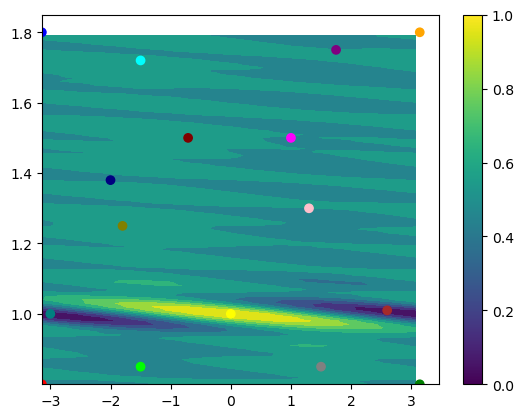

In [9]:
plt.contourf(phase_t,freq_t,loglike,9)
plt.scatter(x0,y0,c=colors)
plt.colorbar();
plt.show()

We need this to set up bounded region of the toy model (outside this range will be rejected)

In [12]:
def out_of_range(x):
    if not (-torch.pi <= x[0] <= torch.pi):
        return False
    if not(0.8 <= x[1] <= 1.8):
        return False
    return True

Range of each parameter
- Phase: $\phi \in [-\pi,\pi]$
- Frequency: $f \in [0.8,1.8]$
- First-order frequency derivative: $\dot{f} \in [-0.002,0.015]$
- Second-order frequency derviative: $\ddot{f} \in [-0.00002,0.00015]$

In [30]:
# Use this if you want 3D or 4D model
# dfreq_t = torch.arange(-0.002,0.015, 0.017/1000)
# ddfreq_t = torch.arange(-0.00002,0.00015, 0.00017/1000)

## Try with varying the phase and freq while keeping dfreq and ddfreq fixed

In [6]:
dfreq = 0.01
ddfreq = 0.001
phase = np.array([-torch.pi, -torch.pi/2,0, torch.pi/2, torch.pi])
freq = np.array([0.8,1,1.4,1.8])
loglike = []

for i in tqdm(range(len(phase))):
    for j in tqdm(range(len(freq))):
        template = torch.tensor([h(ti, phase[i], freq[j], dfreq, ddfreq) for ti in t])
        observed = torch.tensor(np.array([[h(t, phasei, freqi, dfreq, ddfreq) for phasei in phase_t] for freqi in freq_t]))
        logging = log_likelihood(template,observed) 
        loglike.append(logging)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.52s/it]


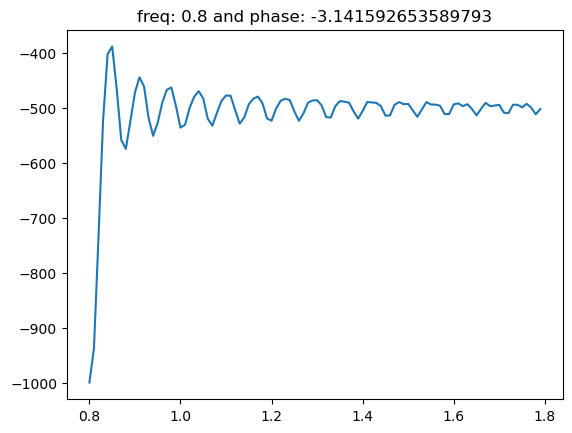

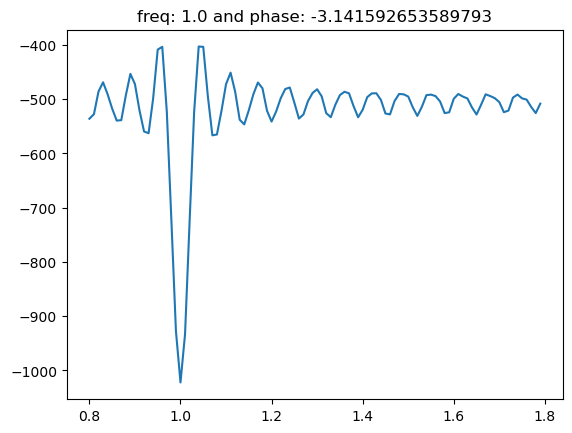

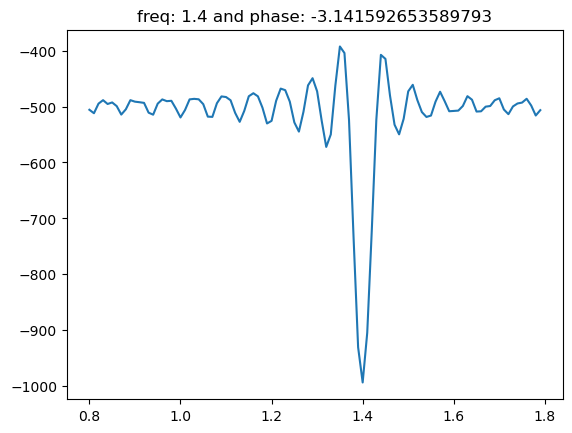

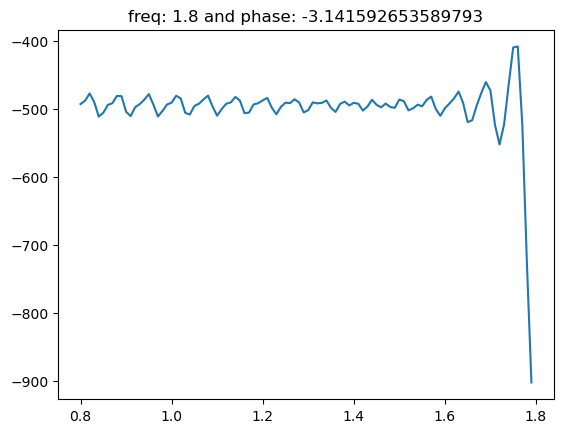

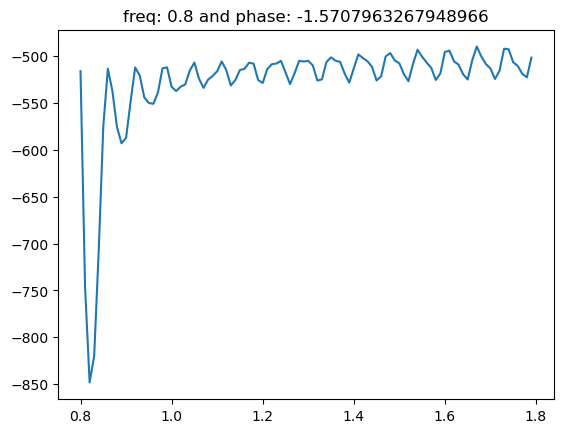

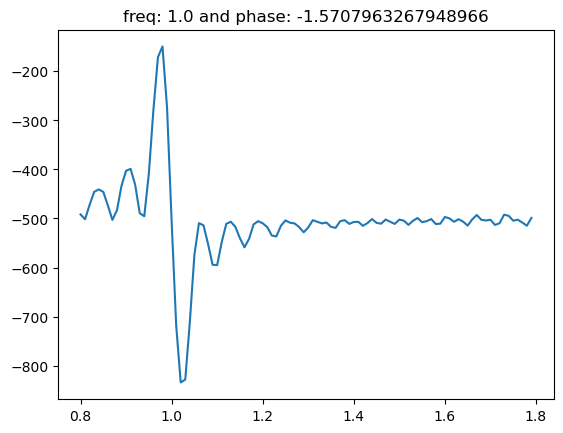

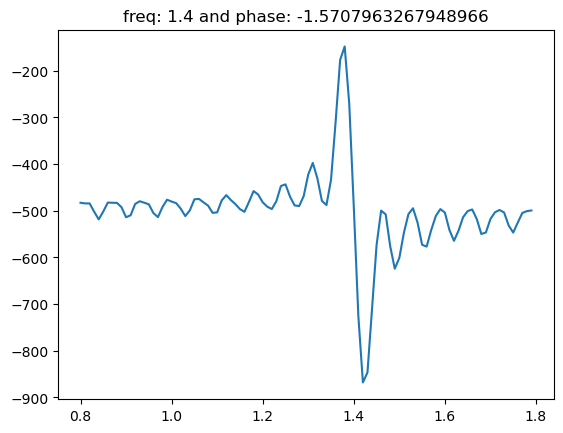

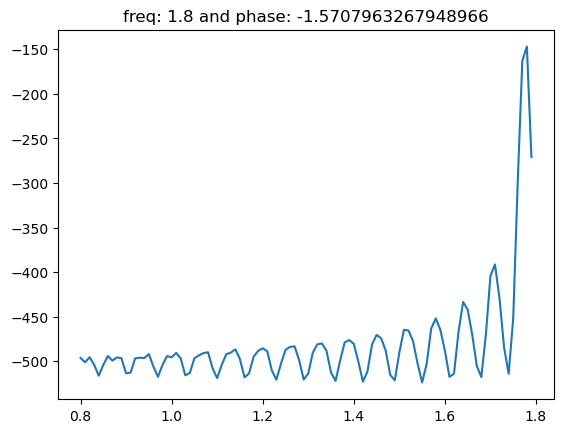

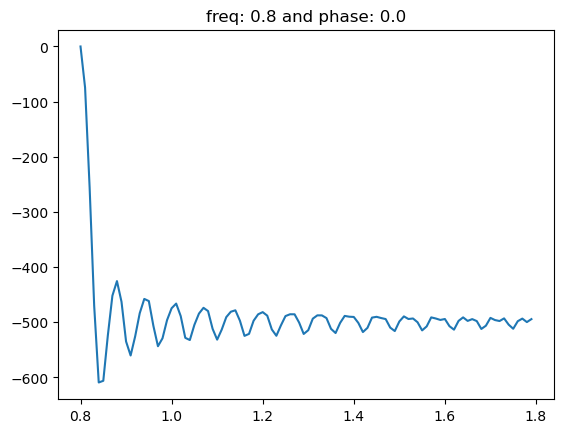

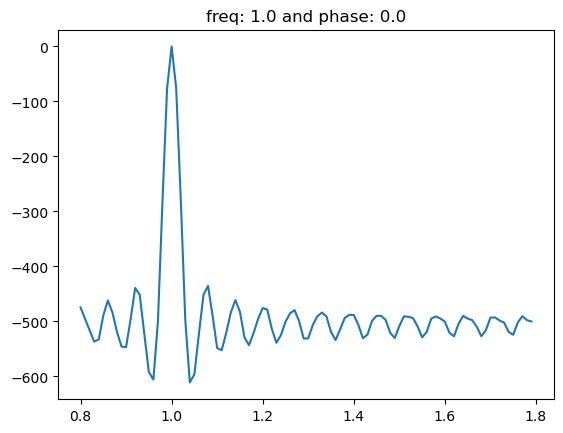

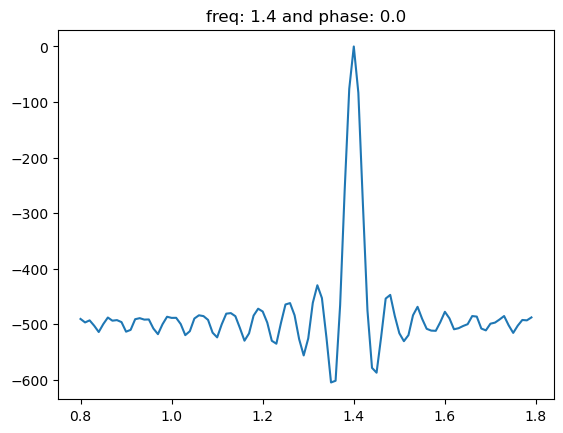

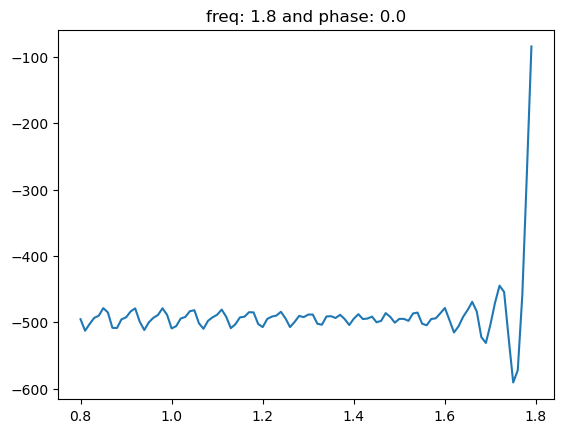

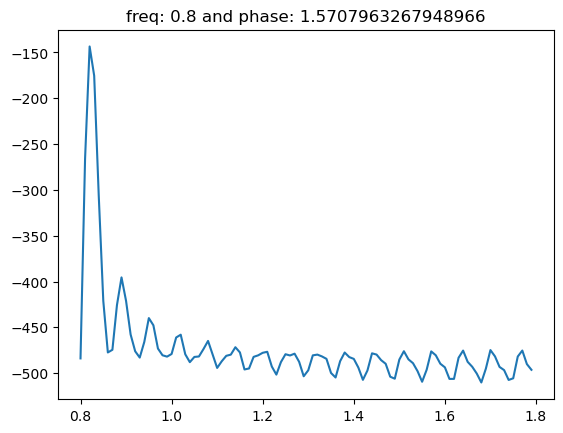

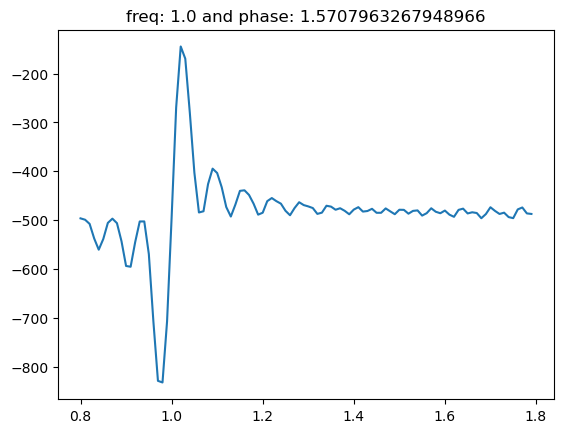

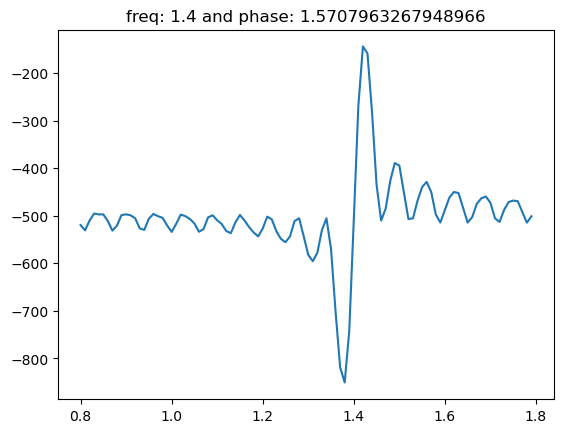

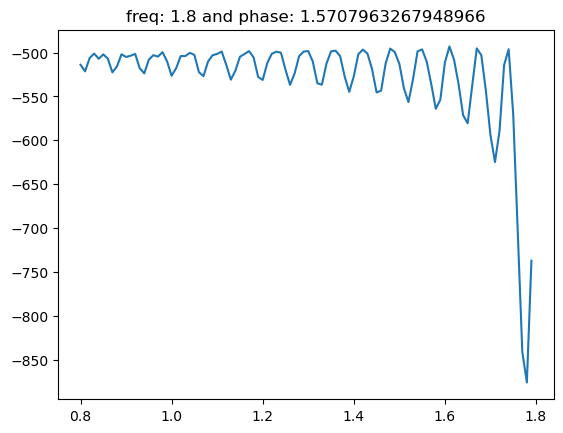

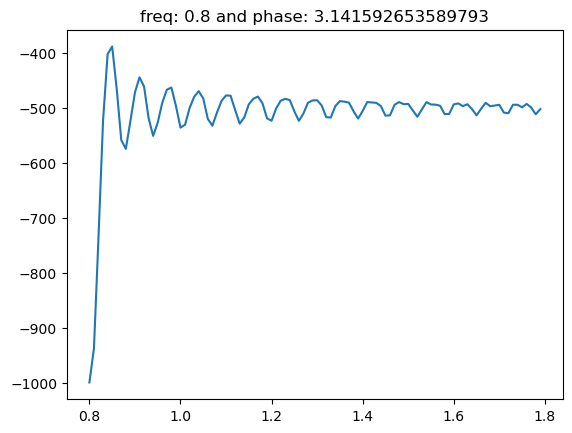

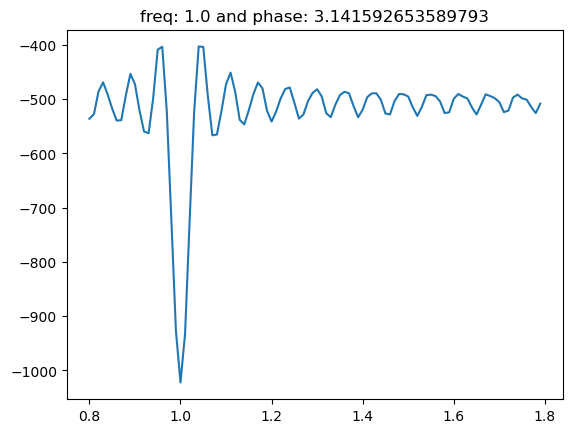

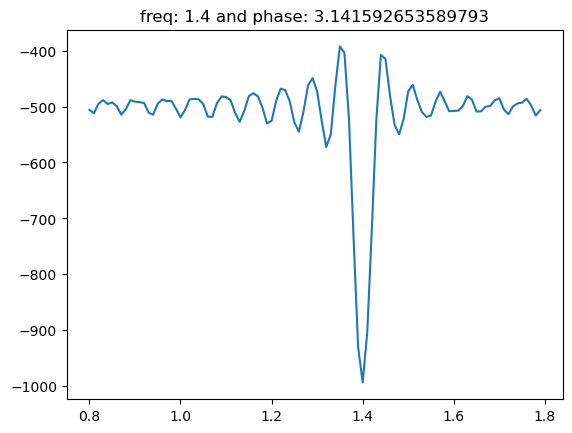

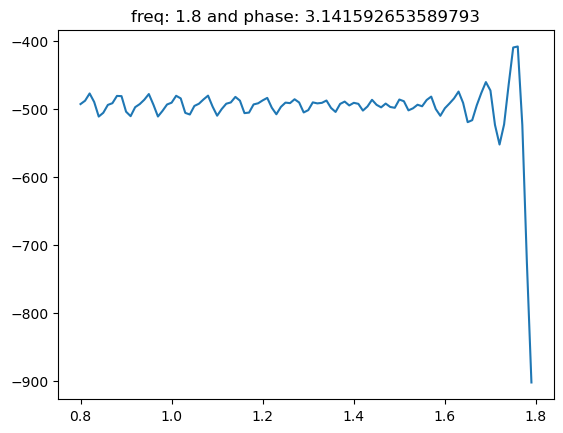

In [7]:
counter = 0
for i in range(len(phase)):
    for j in range(len(freq)):
        counter += 1
        plt.plot(freq_t, loglike[counter-1][:,50])
        plt.title('freq: {} and phase: {}'.format(freq[j], phase[i]))
        plt.show()

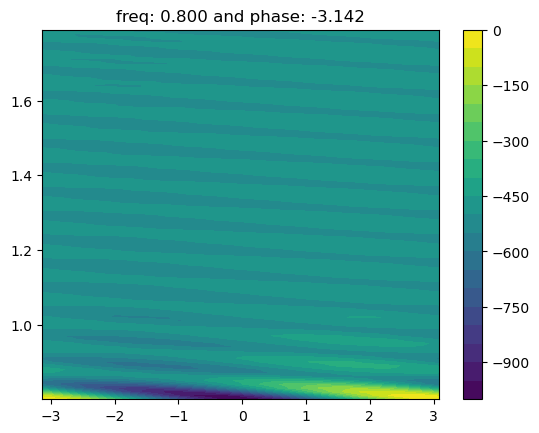

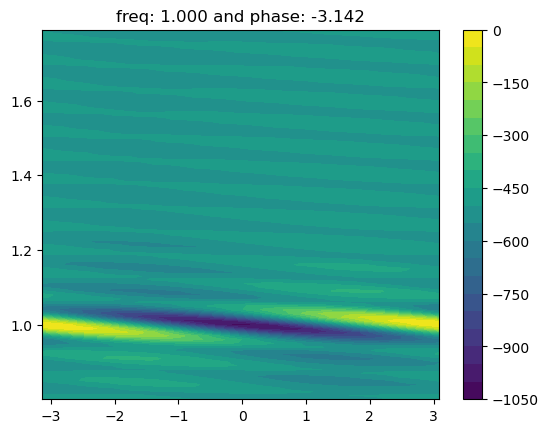

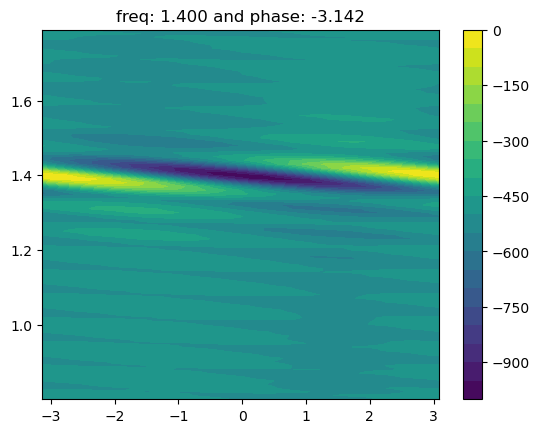

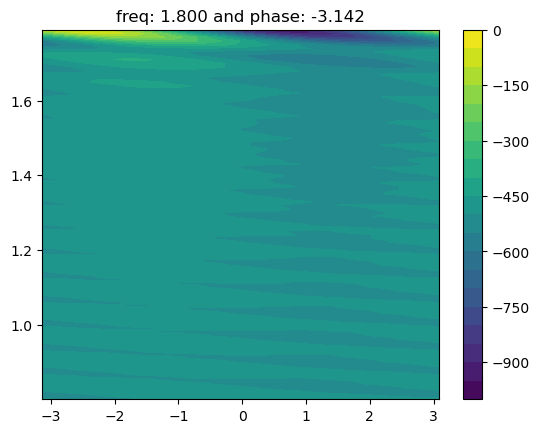

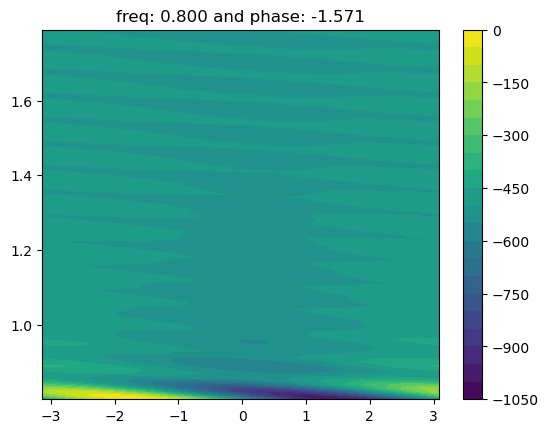

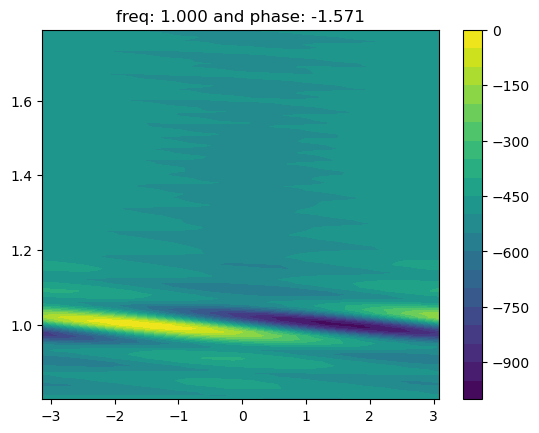

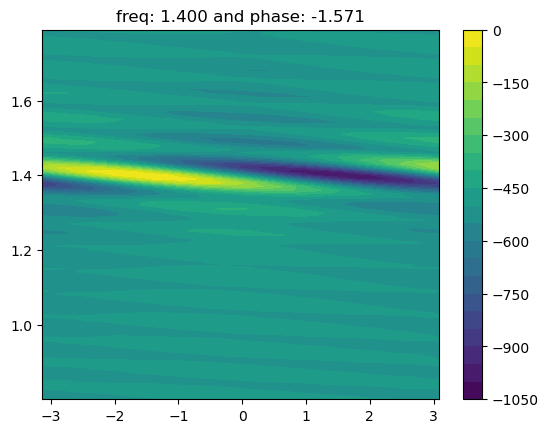

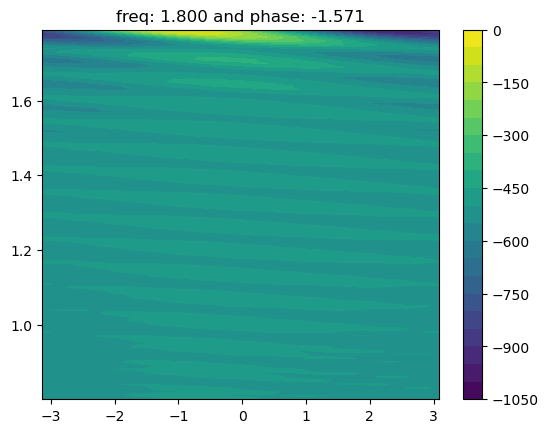

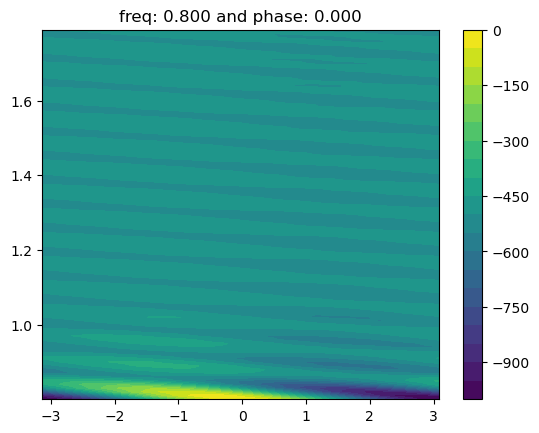

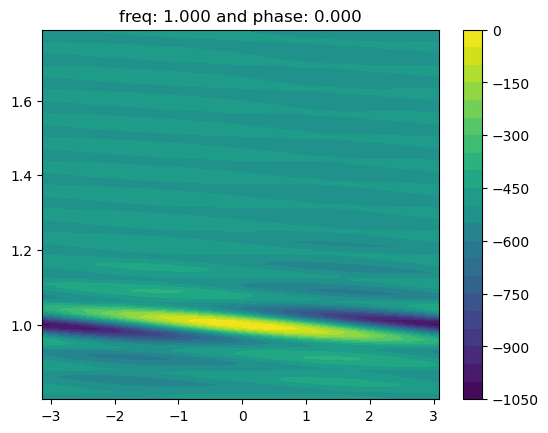

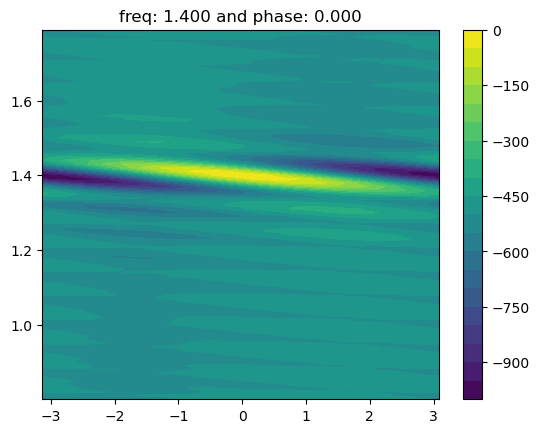

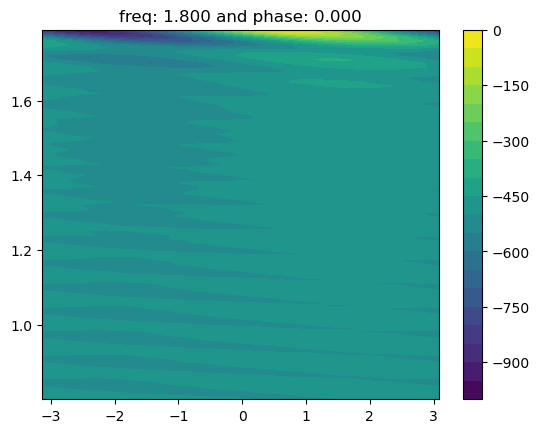

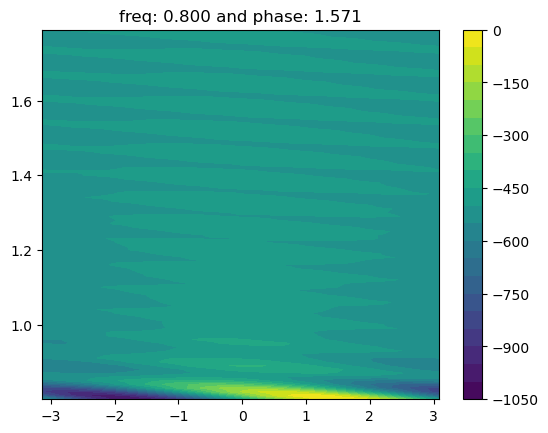

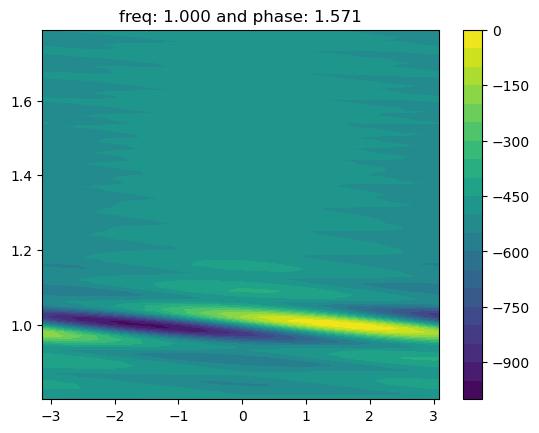

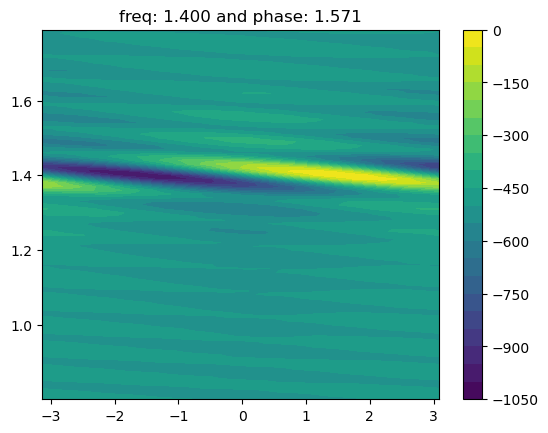

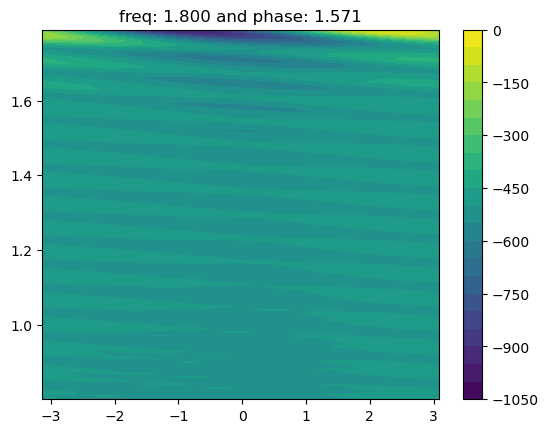

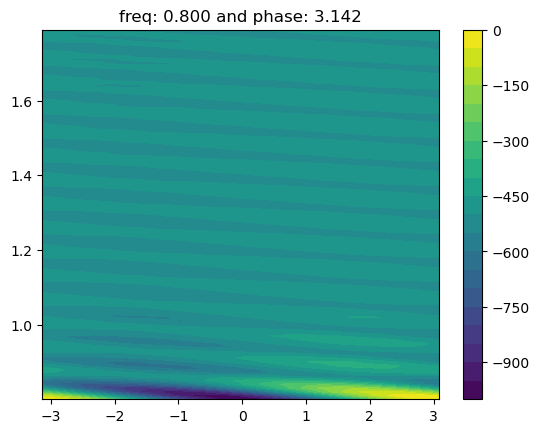

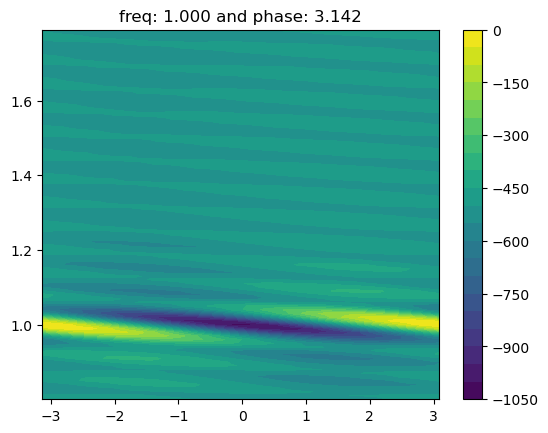

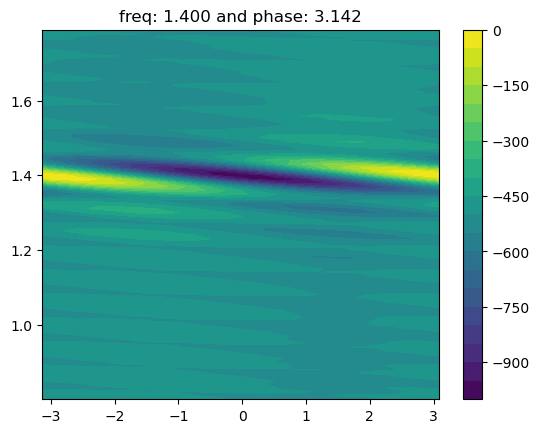

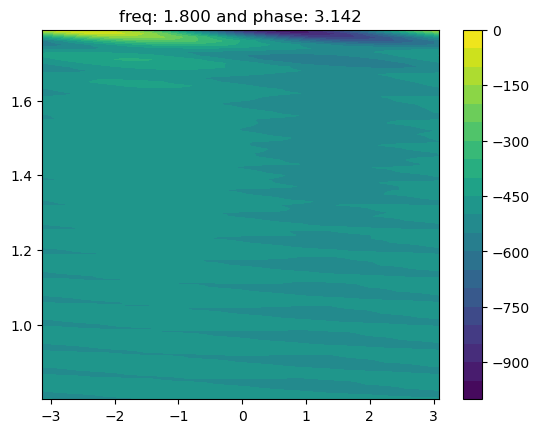

In [8]:
counter = 0
X, Y = np.meshgrid(phase_t, freq_t)
for i in range(len(phase)):
    for j in range(len(freq)):
        counter += 1
        plt.contourf(X,Y, loglike[counter-1],20,cmap='viridis')
        plt.colorbar();
        plt.title('freq: {:.3f} and phase: {:.3f}'.format(freq[j],phase[i]))
        plt.show()

## Our toy model of interest
Phase = 0
Freq = 1

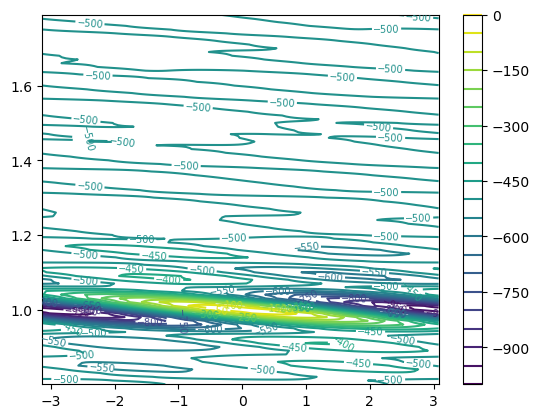

In [11]:
visual = plt.contour(phase_t, freq_t, loglike, 20,cmap='viridis')
# plt.xlim([-3,3])
# plt.ylim([0.8,1.2])
plt.clabel(visual, inline=True, fontsize=7)
plt.colorbar();
plt.show()

# Random Walk Metropolis (RWM) Codes

In [22]:
def rwm_toy(hist_0, x_edges, y_edges, chainlen, Z0, c, d):
    count = []
    sample1 = []
    timetaken = []
    kl_divergence = []
    ess = []
    burnin = int(chainlen/2)
    for i in range(len(Z0)):
        tic = time.time()
        Zi = [Z0[i]]
        counts = 0
        for j in tqdm(range(chainlen)):
            x = Zi[j]
            x_prop = random.multivariate_normal(x,[[c,0],[0,d*c]]) # Using multinorm proposal here, should be symmetric
                
            new_prop = h(t,x_prop[0],x_prop[1],dfreq,ddfreq)
            log_prop = log_likelihood(template, new_prop) # proposal is -U(x)
            #if out_of_range(x_prop) == False:
            #    log_prop = -np.inf    
            #print(x, x_prop, log_prop)
            new_x = h(t,x[0],x[1],dfreq,ddfreq)
            log_like = log_likelihood(template, new_x) 
            
            #print(log_like, log_prop)
            
            accept = MHstep.log_MHstep(log_prop, log_like, Kernels.symmetric(1), Kernels.symmetric(1))
            if accept == 1:
                #sample0.append(x_prop)
                Zi.append(x_prop)
            else:
                #sample0.append(x)
                Zi.append(x)
            if j >= burnin:
                counts += accept
        sample1.append(Zi)
        count.append(counts)
        timing = time.time() - tic
        timetaken.append(timing)
        #print(np.array(Zi).shape)
        
        hist_A, _, _ = np.histogram2d(np.array(sample1)[i][burnin:,0], np.array(sample1)[i][burnin:,1], bins=[x_edges, y_edges], density=True)

        prob_A = hist_A / np.sum(hist_A)
        prob_0 = hist_0 / np.sum(hist_0)
        
        prob_A_flat = prob_A.flatten()
        prob_0_flat = prob_0.flatten()
        
        epsilon = 1e-10
        prob_A_flat += epsilon
        prob_0_flat += epsilon

        kl_divergenced = entropy(prob_A_flat, prob_0_flat)
        kl_divergence.append(kl_divergenced)

        ess0 = np.array([neff(np.array(sample1)[i, burnin:,k]) for k in range(2)])
        ess.append(ess0)
        
    return timetaken, count, np.array(sample1), kl_divergence, ess

In [23]:
c = np.array([1,0.1,0.01])
d = np.array([1,0.1])

timetaken = []
count = []
values = []
kl_divergence = []
ess = []

for i in range(len(c)):
    for j in range(len(d)):
        timing, x, y, z, e = rwm_toy(hist_0, x_edges, y_edges, chainlen, Z0, c[i], d[j])
        timetaken.append(timing)
        count.append(x)
        values.append(y)
        kl_divergence.append(z)
        ess.append(e)

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:02<00:00, 3366.51it/s]
C:\Users\justi\anaconda3\Lib\site-packages\numpy\lib\histograms.py:1067: RuntimeWarning: invalid value encountered in divide
  hist /= s
100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:03<00:00, 3304.83it/s]


In [13]:
# Checking the shapes
np.array(values).shape, np.array(timetaken).shape, np.array(count).shape, np.array(kl_divergence).shape, np.array(ess).shape

((6, 16, 10001, 2), (6, 16), (6, 16), (6, 16), (6, 16, 2))

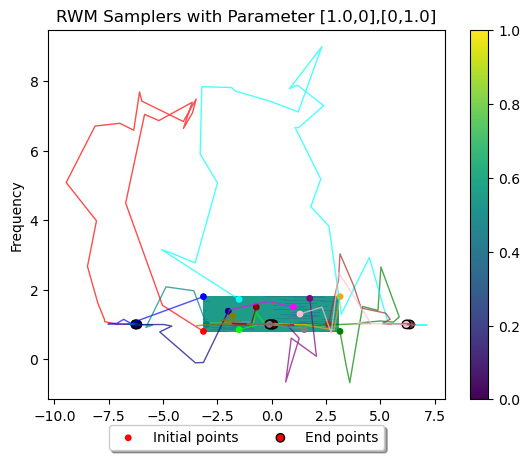

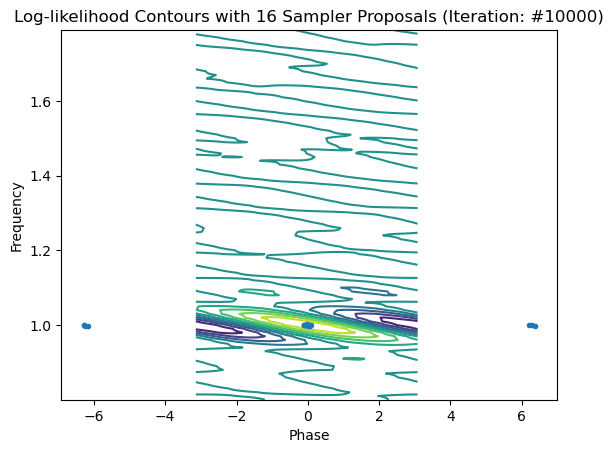

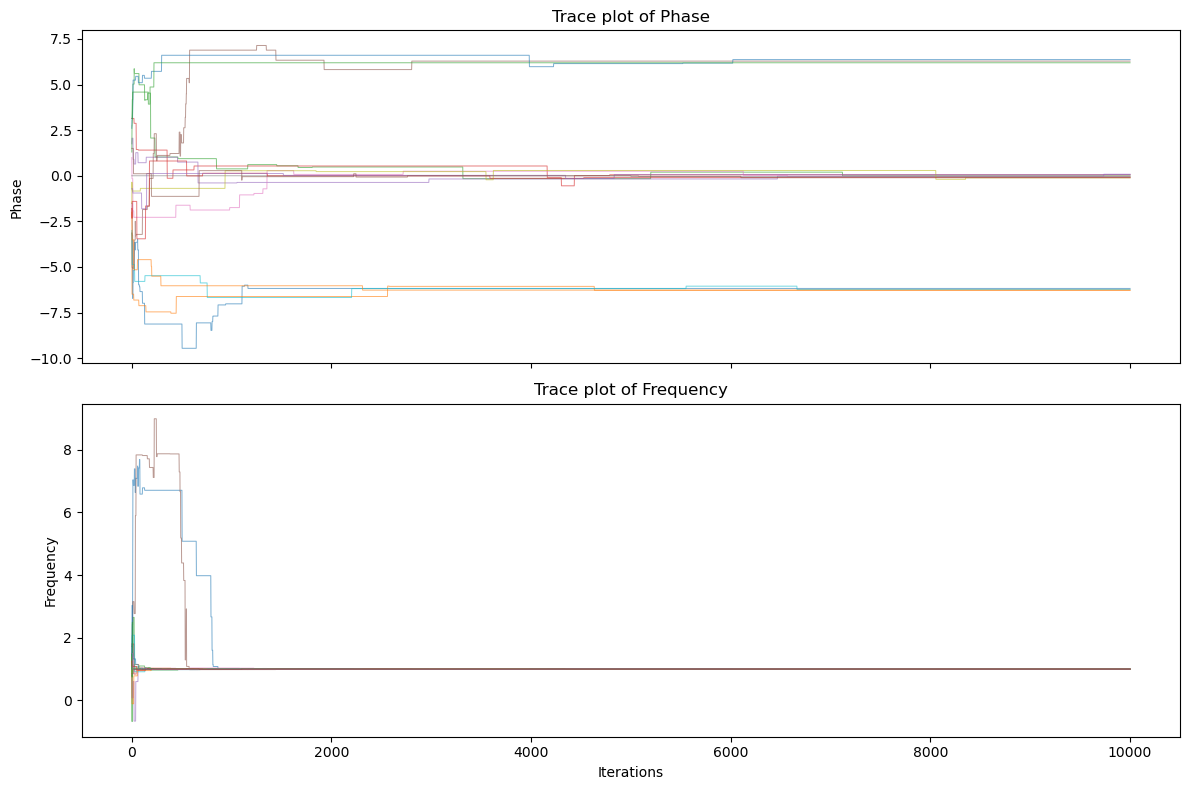

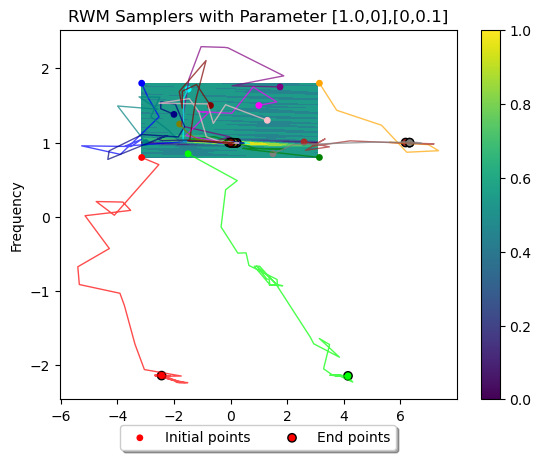

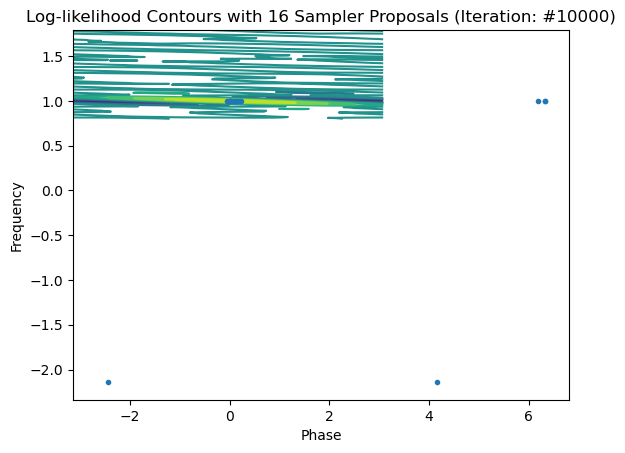

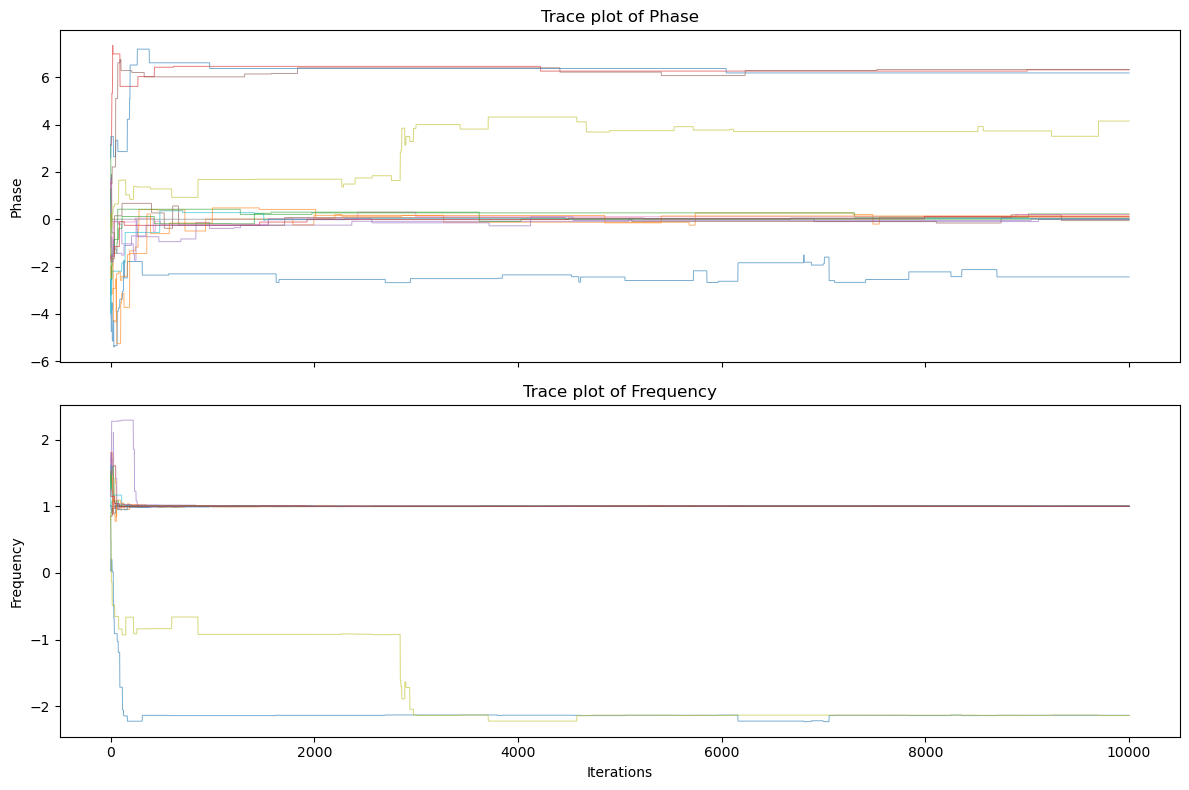

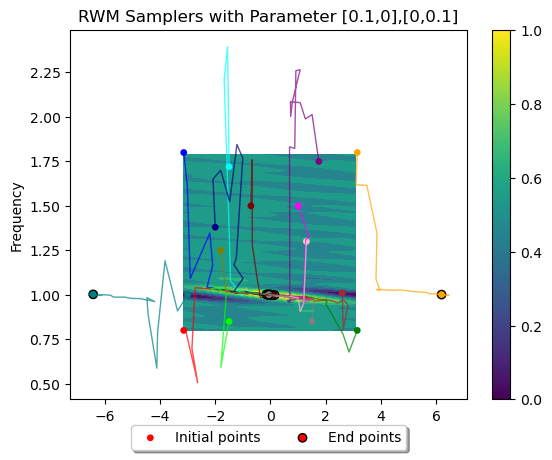

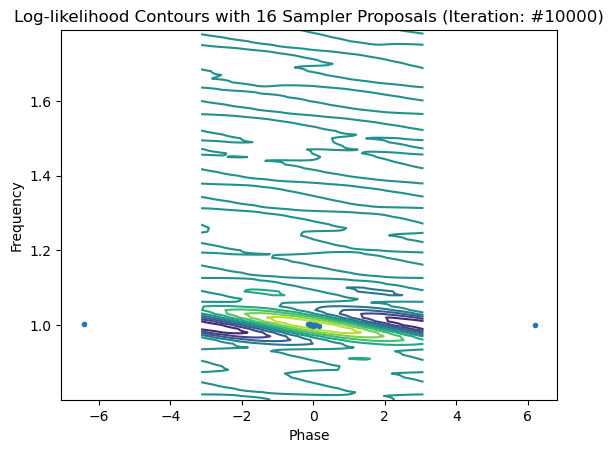

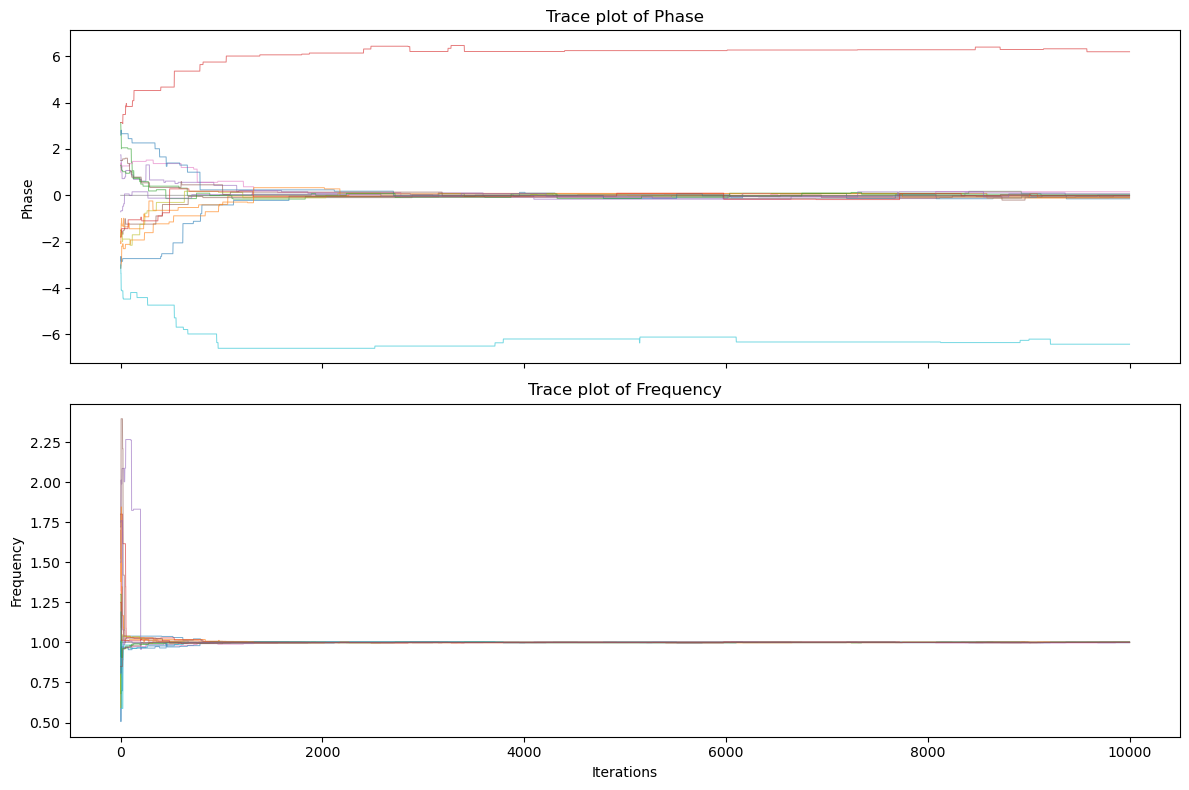

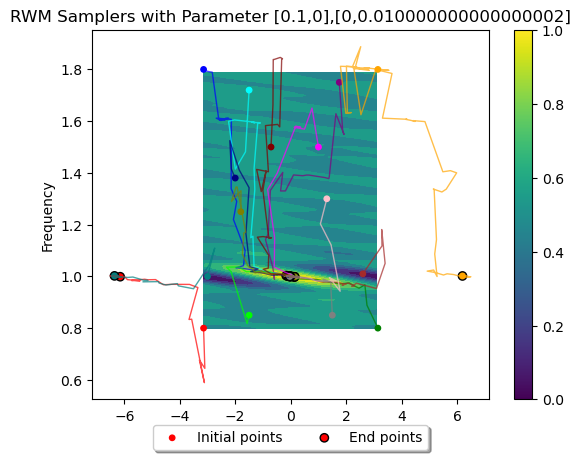

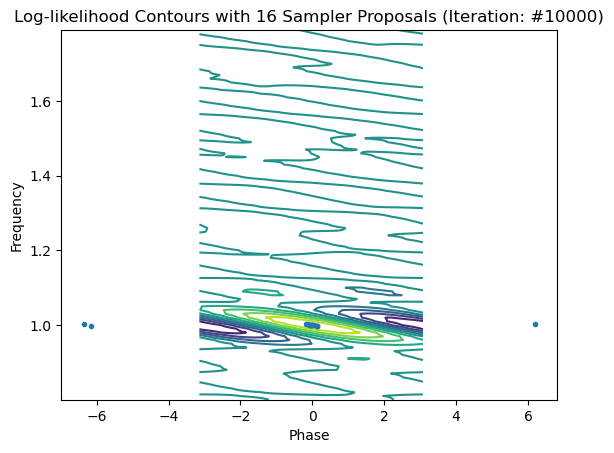

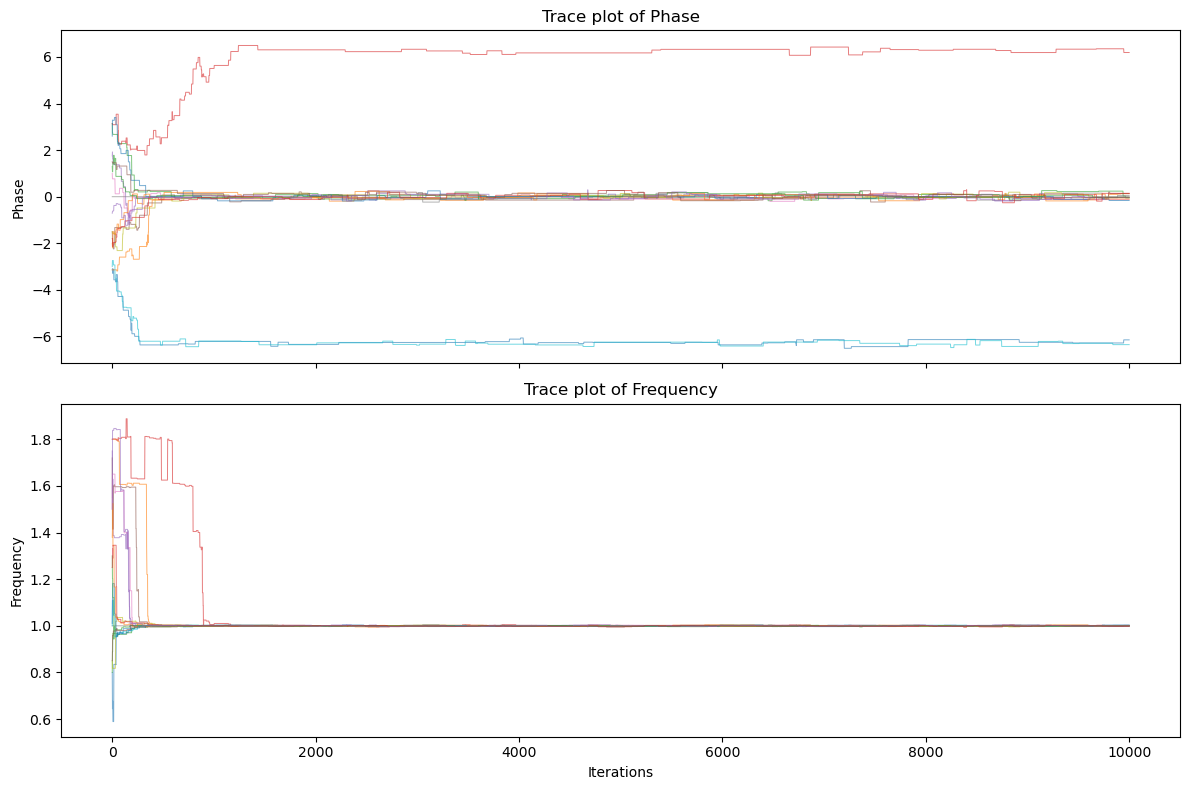

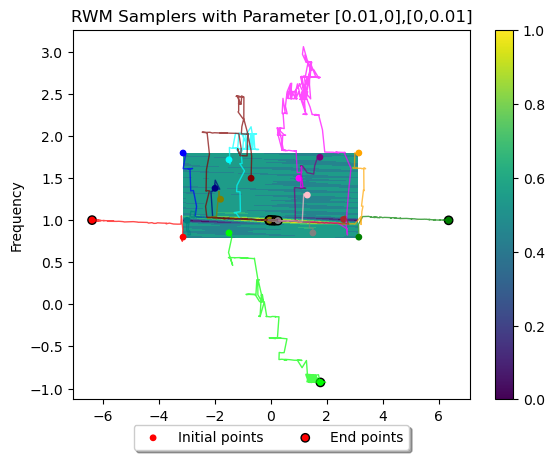

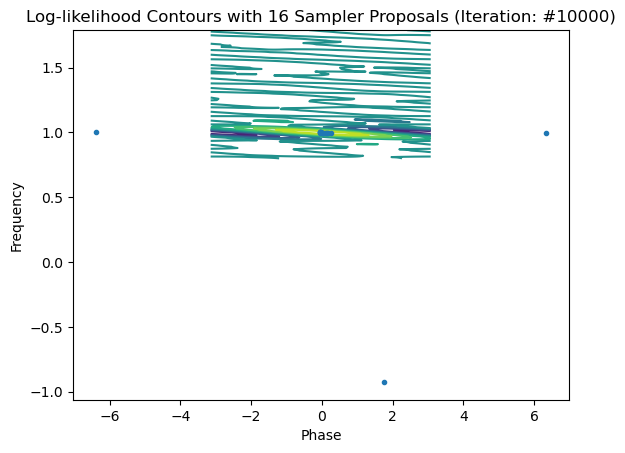

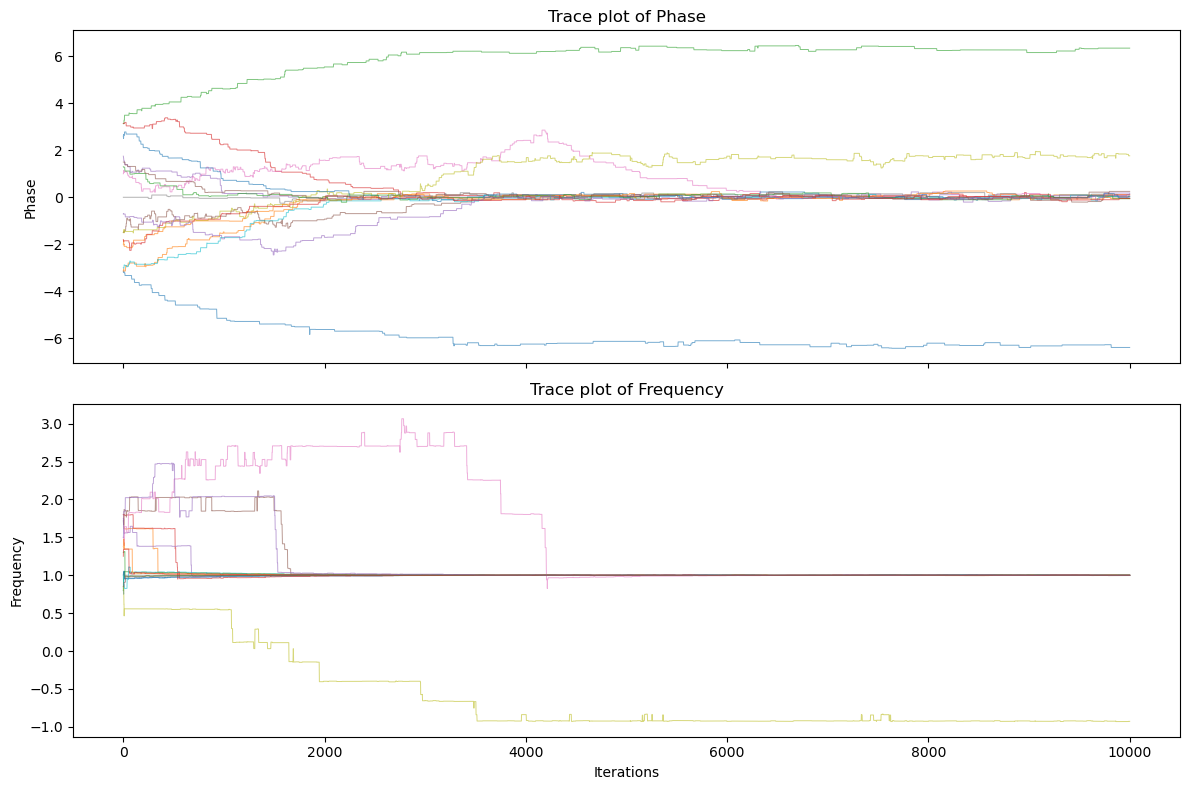

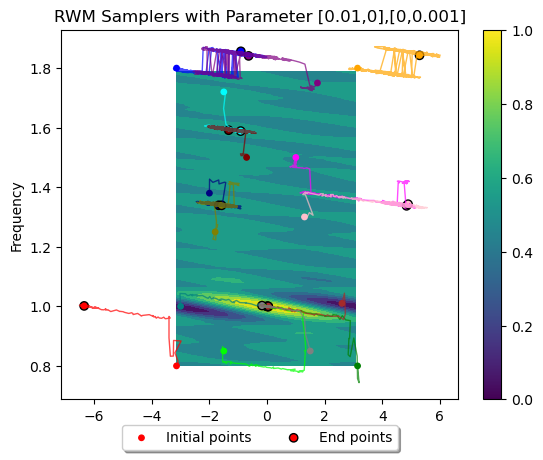

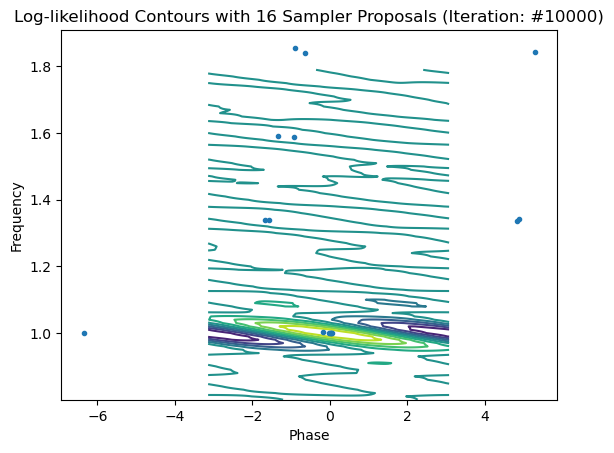

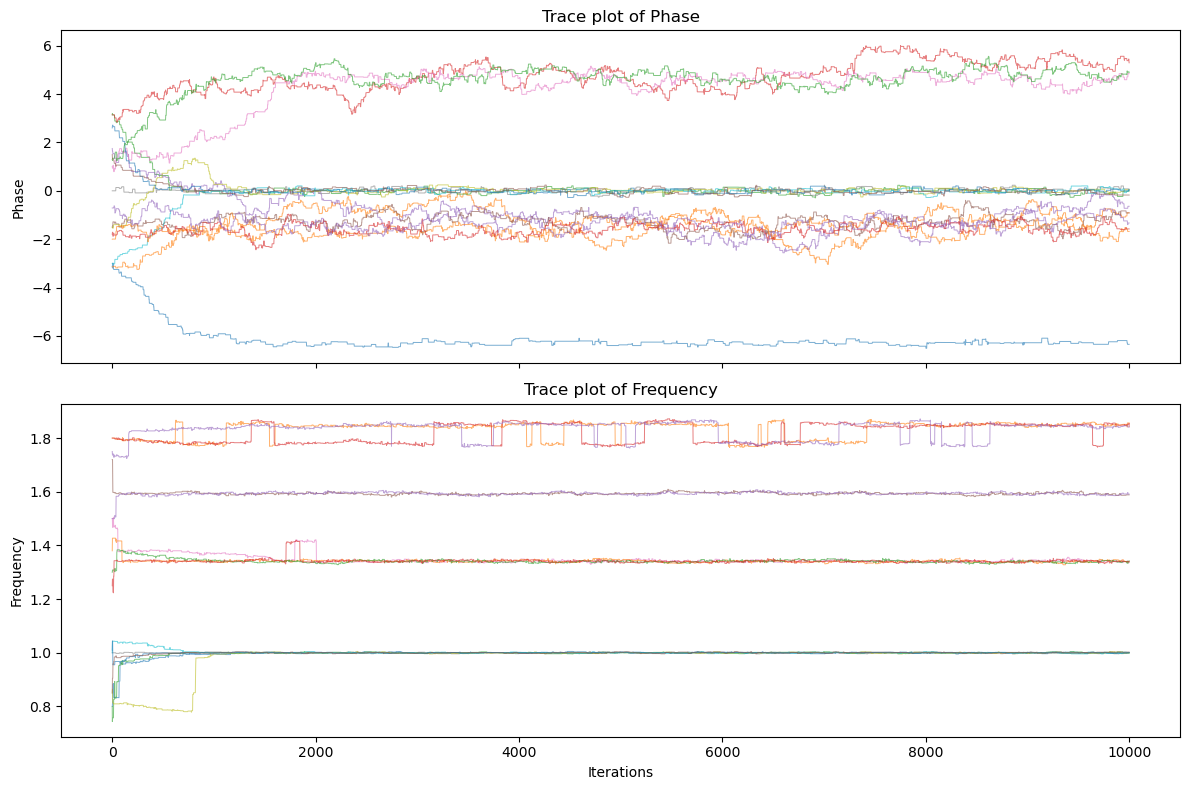

In [25]:
counter = 0
for i in range(len(c)):
    for j in range(len(d)):
        counter += 1
        plt.contourf(phase_t, freq_t, loglike, 10)
        plt.scatter(x0,y0,c=colors,s=15, marker='o', label='Initial points')
        plt.scatter(values[counter-1][:,10000,0], values[counter-1][:,10000,1], color=colors, edgecolors='k',marker='o', label='End points')
        for k in range(np.array(values).shape[1]):
            plt.plot(values[counter-1][k, :, 0], values[counter-1][k, :, 1], color=colors[k], alpha=0.7, linewidth=1)
        #plt.plot(values[counter-1][:,:,0].flatten(), values[counter-1][:,:,1].flatten(), '.', alpha=0.6)
        #plt.xlim([-3.5, 3.5])
        #plt.ylim([0.6, 2])
        plt.xlabel('Phase')
        plt.ylabel('Frequency')
        plt.colorbar();
        plt.title('RWM Samplers with Parameter [{},0],[0,{}]'.format(c[i],d[j]*c[i]))
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
        plt.show()

        xp_np = np.array(values[counter-1][:,10000,:])
        plt.contour(phase_t, freq_t, loglike, levels=10, cmap='viridis')
        plt.plot(xp_np[:,0],xp_np[:,1],'.')
        plt.xlabel('Phase')
        plt.ylabel('Frequency')
        plt.title('Log-likelihood Contours with 16 Sampler Proposals (Iteration: #10000)')
        #plt.xlim([-3.5, 3.5])
        #plt.ylim([0.6, 2])
        plt.show()

        xp_np = np.array(values[counter-1])
        iterations = xp_np.shape[1]

        param_names = ['Phase', 'Frequency']

        fig, axes = plt.subplots(nrows=2, figsize=(12, 8), sharex=True)

        # Loop over each parameter (e.g., Phase and Frequency)
        for param_idx in range(2):
            ax = axes[param_idx]
            for chain_idx in range(xp_np.shape[0]):
                ax.plot(
                    np.arange(iterations),
                    xp_np[chain_idx, :, param_idx],
                    alpha=0.6,
                    linewidth=0.7
                )
            ax.set_ylabel(f'{param_names[param_idx]}')
            ax.set_title(f'Trace plot of {param_names[param_idx]}')
        
        axes[-1].set_xlabel('Iterations')
        
        plt.tight_layout()
        plt.show()

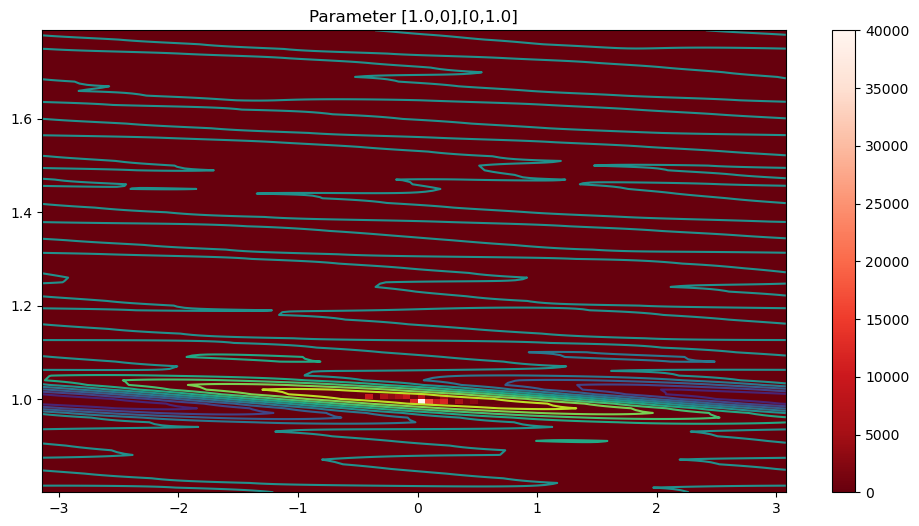

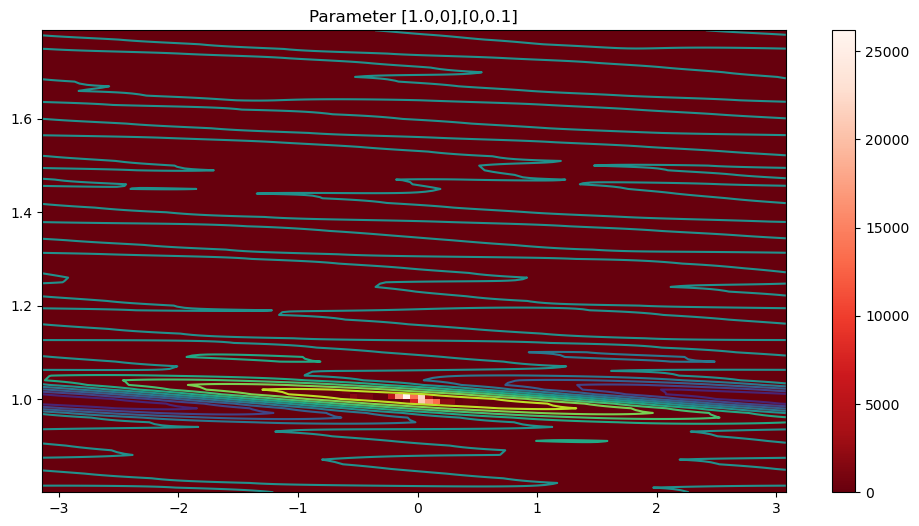

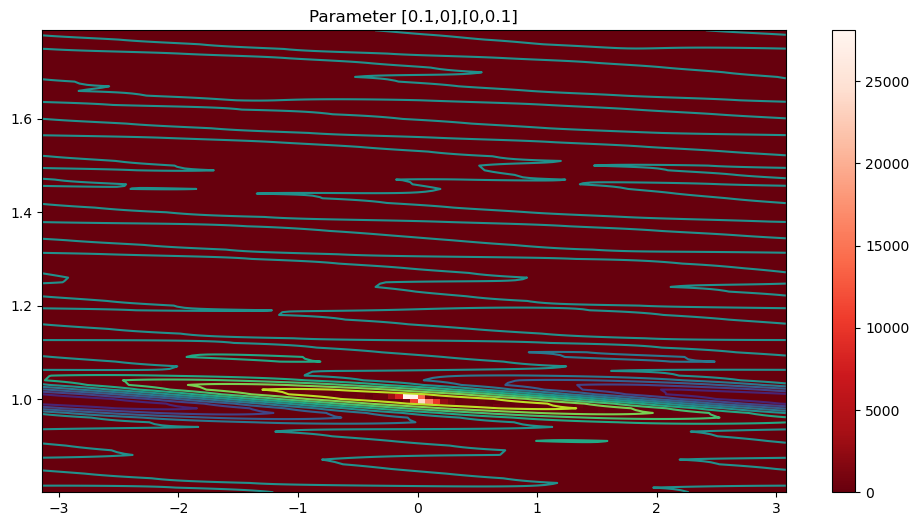

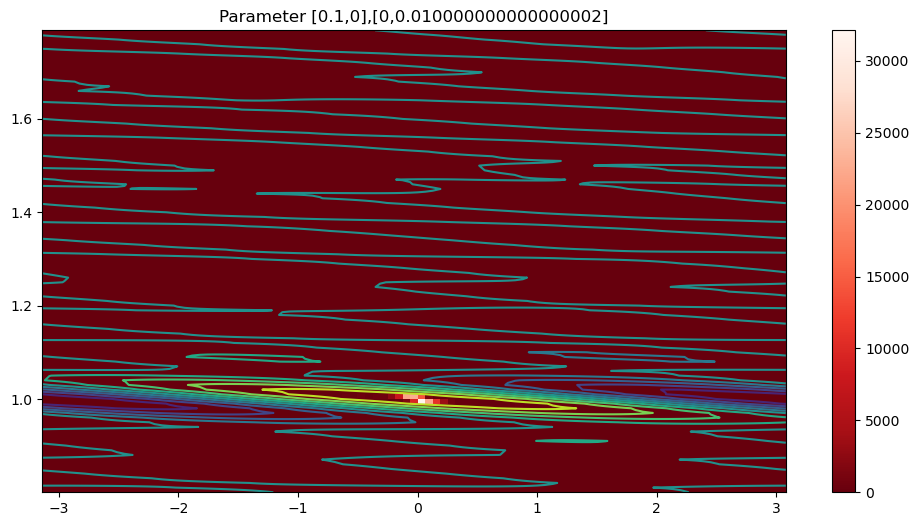

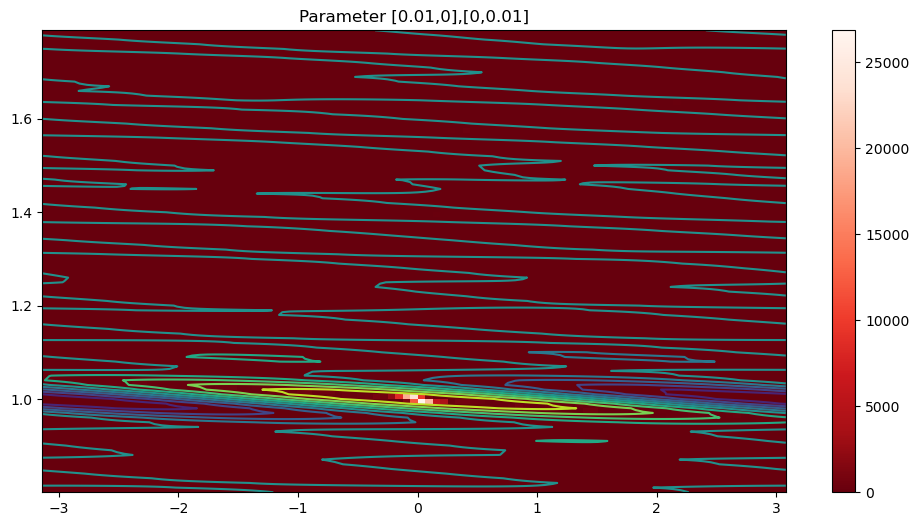

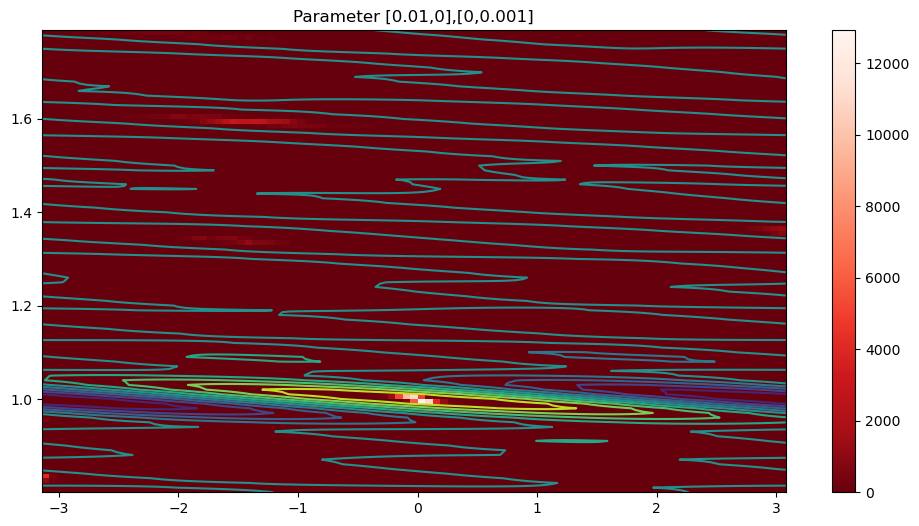

In [18]:
counter = 0
for i in range(len(c)):
    for j in range(len(d)):
        counter += 1
        
        plt.figure(figsize=(12, 6))
        
        plt.contour(phase_t, freq_t, loglike, 9)
        plt.hist2d(values[counter-1][:,:,0].flatten(), values[counter-1][:,:,1].flatten(), bins=[phase_t, freq_t],cmap=plt.cm.Reds_r)
        #plt.gca().set_aspect('equal')
        # plt.xlim(-1,1)
        # plt.ylim(0.9,1.2)
        plt.title('Parameter [{},0],[0,{}]'.format(c[i],d[j]*c[i]))
        plt.colorbar();
        plt.show()

### Evaluation Metrics for RWM

In [26]:
counter = 0
for i in range(len(c)):
    for j in range(len(d)):
        counter += 1
        for k in range(n_sample):
            per_accept = np.array(count)[counter-1][k] / chainlen * 100
            print('Chain {}: Given parameter c = {}, and d = {}, {:.2f} % accepted overall, Time taken: {:.3f}s, \nKL Divergence: {:.4f} and ESS for x0: {:.3f}, x1: {:.3f}'
                  .format(k+1, c[i], d[j], np.mean(per_accept), np.array(timetaken)[counter-1][k], kl_divergence[counter-1][k], ess[counter-1][k][0], ess[counter-1][k][1]))

Chain 1: Given parameter c = 1.0, and d = 1.0, 0.00 % accepted overall, Time taken: 2.973s, 
KL Divergence: nan and ESS for x0: 1.500, x1: nan
Chain 2: Given parameter c = 1.0, and d = 1.0, 0.00 % accepted overall, Time taken: 2.988s, 
KL Divergence: nan and ESS for x0: 1.500, x1: nan
Chain 3: Given parameter c = 1.0, and d = 1.0, 0.02 % accepted overall, Time taken: 2.980s, 
KL Divergence: 9.2332 and ESS for x0: 11.317, x1: 7.135
Chain 4: Given parameter c = 1.0, and d = 1.0, 0.00 % accepted overall, Time taken: 2.974s, 
KL Divergence: 10.0901 and ESS for x0: 1.500, x1: 1.500
Chain 5: Given parameter c = 1.0, and d = 1.0, 0.02 % accepted overall, Time taken: 2.980s, 
KL Divergence: 9.1740 and ESS for x0: 7.016, x1: 42.628
Chain 6: Given parameter c = 1.0, and d = 1.0, 0.00 % accepted overall, Time taken: 2.979s, 
KL Divergence: nan and ESS for x0: 1.500, x1: nan
Chain 7: Given parameter c = 1.0, and d = 1.0, 0.02 % accepted overall, Time taken: 3.152s, 
KL Divergence: 9.1907 and ESS f

In [27]:
np.sum(np.array(timetaken),axis=1), np.nanmean(kl_divergence,axis=1), np.nanmean(ess,axis=1)

(array([48.20840049, 52.65864158, 49.2729218 , 47.93608856, 47.63613009,
        47.74330425]),
 array([9.61262838, 9.37645528, 9.01864361, 8.22348855, 8.21847256,
        7.49841202]),
 array([[  5.06159495,  10.58353552],
        [ 26.18856936,  17.60263946],
        [ 37.43871764,  39.66170579],
        [ 98.04027134,  93.12603886],
        [ 78.5020165 ,  71.10622355],
        [135.11214273, 166.22041218]]))

In [28]:
np.mean((np.array(count)/chainlen),axis=1)

array([8.75000e-05, 3.25000e-04, 5.12500e-04, 2.02500e-03, 4.35000e-03,
       2.90125e-02])

# Metropolis Adjusted Langevin Algorithm (MALA) Codes

In [29]:
# We define this as the code does not work with the h function
def h_plus(t, target, dfreq, ddfreq):
    try:
        target[0][0]
    except IndexError:
        return torch.sin(target[0] + target[1]*t + dfreq*t**2 + ddfreq*t**3)
    return torch.sin(target[0][0] + target[0][1]*t + dfreq*t**2 + ddfreq*t**3)

We set up manual gradient instead of auto grad (the result should be the same)

In [30]:
def manual_grad_log_likelihood(template, observed):
    """
    Calculates the gradient of the log-likelihood function manually.

    Args:
        template: The template waveform.
        observed: The observed data.
        t: Time points.
        phase: Phase parameter.
        freq: Frequency parameter.
        dfreq: First-order frequency derivative.
        ddfreq: Second-order frequency derivative.

    Returns:
        A torch tensor representing the gradient.
    """

    difference = observed - template

    # Partial derivative w.r.t phase
    grad_phase = torch.mean(difference * torch.cos(phase + freq*t + dfreq*t**2 + ddfreq*t**3)) 

    # Partial derivative w.r.t frequency
    grad_freq = torch.mean(difference * torch.cos(phase + freq*t + dfreq*t**2 + ddfreq*t**3) * t)

    return torch.tensor([grad_phase, grad_freq]) 

In [31]:
def log_Q(potential, z_prime, z, step):
    z.requires_grad_()
    z_new = h_plus(t,z,dfreq,ddfreq)
    u = potential(template, z_new).mean()
        
    #grad = torch.autograd.grad(u, z)[0]
    grad = manual_grad_log_likelihood(template, z_new)
    
    return -(torch.norm(z_prime - z + step * grad, p=2, dim=1) ** 2) / (4 * step)

In [51]:
def mala_toy(hist_0, x_edges, y_edges, Z0, chainlen, step):
    count = []
    sample1 = []
    true_samples = []
    grad1 = []
    timetaken = []
    burnin = int(chainlen/2)
    kl_divergence = []
    ess = []
    for i in range(len(Z0)):
        tic = time.time()
        Zi = Z0.cpu().detach()[i]
        
        sample0 = []
        grad0 = []
        counts = 0
        for j in tqdm(range(chainlen)):
            Zi.requires_grad_()
            x = h_plus(t,Zi,dfreq,ddfreq)
            u = -log_likelihood(template, x).mean()
            grad = torch.autograd.grad(u, Zi)[0]
            #print(grad)
            grad = torch.tensor(manual_grad_log_likelihood(template, x),dtype= torch.float64)
            #print(grad)
            prop_Zi = Zi.detach() - step * grad + np.sqrt(2 * step) * torch.randn(1,2)

            x_prop = h_plus(t,prop_Zi,dfreq,ddfreq)
            #print('1st label {} and {}'.format(Zi, prop_Zi))
            log_like = log_likelihood(template,x).mean()
            log_prop = log_likelihood(template,x_prop).mean()
            
            #if out_of_range(prop_Zi[0]) == False:
            #    log_prop = -np.inf
                
            kernel_prop = log_Q(log_likelihood, Zi, prop_Zi, step)
            kernel_z = log_Q(log_likelihood, prop_Zi, Zi, step)
            #print(log_like, log_prop)
            #print('3rd label {} and {}'.format(kernel_prop, kernel_z))
            
            accept = MHstep.torch_logstep(log_prop, log_like, kernel_prop, kernel_z)
            #print('accept = {:.0f}'.format(accept))
            if accept == 1:
                Zi = prop_Zi
        
            if j >= burnin:
                counts += accept
            sample0.append(Zi.detach().numpy())
            grad0.append(grad.detach().numpy())
        count.append(counts)
        timing = time.time() - tic
        timetaken.append(timing)
        true_samples.append(np.vstack(sample0))
        samples = np.vstack(sample0)[burnin:]
        grads = np.vstack(grad0)[burnin:]
        sample1.append(samples)
        grad1.append(grads)

        hist_A, _, _ = np.histogram2d(np.array(sample1)[i][:,0], np.array(sample1)[i][:,1], bins=[x_edges, y_edges], density=True)

        prob_A = hist_A / np.sum(hist_A)
        prob_0 = hist_0 / np.sum(hist_0)
        
        prob_A_flat = prob_A.flatten()
        prob_0_flat = prob_0.flatten()
        
        epsilon = 1e-10
        prob_A_flat += epsilon
        prob_0_flat += epsilon

        kl_divergenced = entropy(prob_A_flat, prob_0_flat)
        kl_divergence.append(kl_divergenced)

        ess0 = np.array([neff(np.array(sample1)[i,:,k]) for k in range(2)])
        ess.append(ess0)
        
    return timetaken, count, np.array(true_samples), np.array(grad1), np.array(kl_divergence), np.array(ess)

In [61]:
step = torch.tensor([0.00001, 0.001, 0.1])

timetaken2 = []
count2 = []
values2 = []
grad2 = []
kl_divergence2 = []
ess2 = []

for i in range(len(step)):
    tt, x, value2, g, z, e = mala_toy(np.array(loglike), x_edges, y_edges, Z0, chainlen, step[i])
    timetaken2.append(tt)
    count2.append(x)
    values2.append(value2)
    grad2.append(g)
    kl_divergence2.append(z)
    ess2.append(e)

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]C:\Users\justi\AppData\Local\Temp\ipykernel_14016\1284048305.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  grad = torch.tensor(manual_grad_log_likelihood(template, x),dtype= torch.float64)
100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 400.33it/s]


In [53]:
# Checking the shape
np.array(values2).shape, np.array(grad2).shape, np.array(kl_divergence2).shape

((3, 16, 10000, 2), (3, 16, 5000, 2), (3, 16))

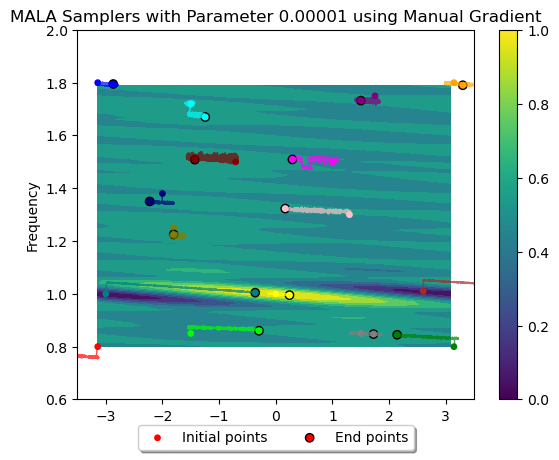

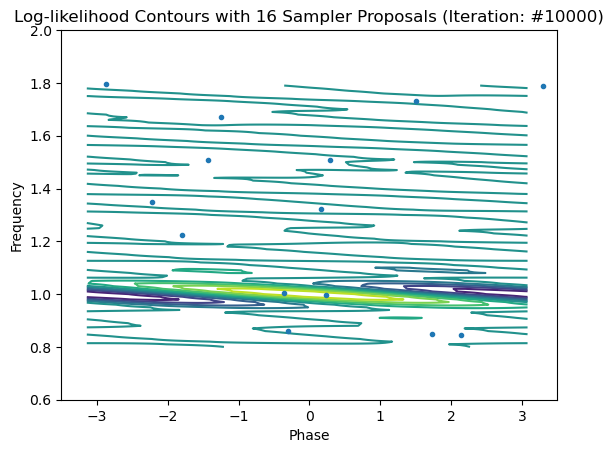

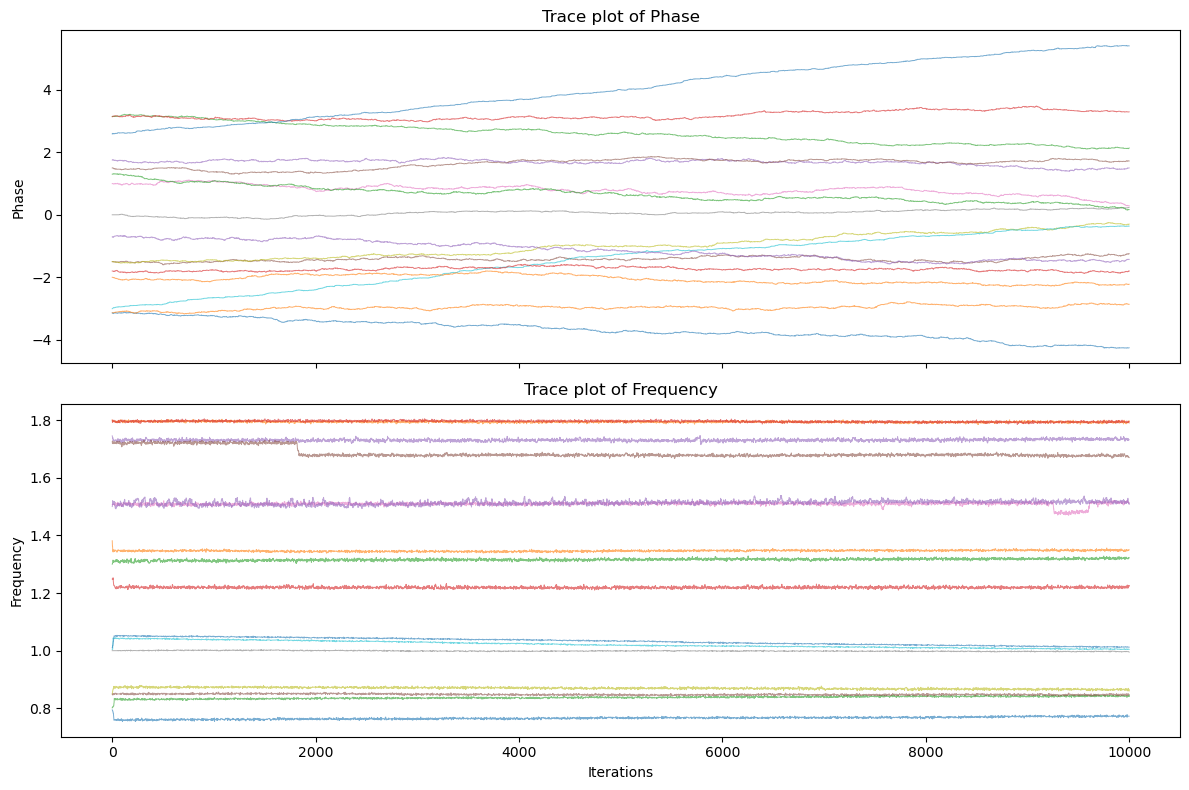

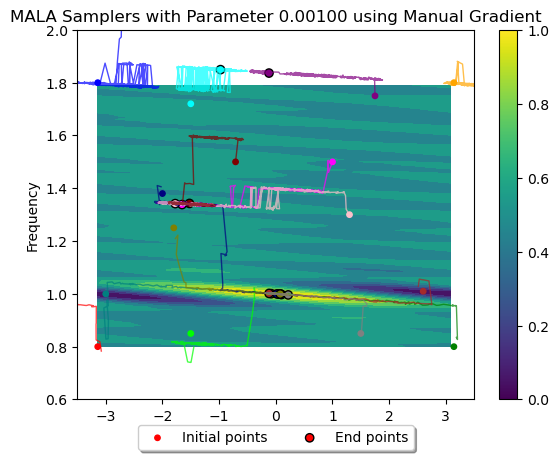

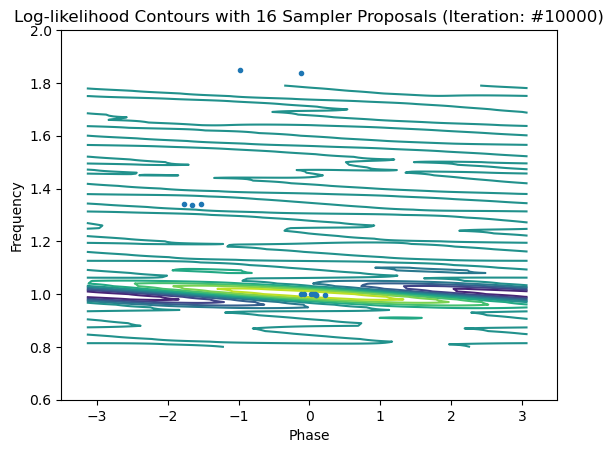

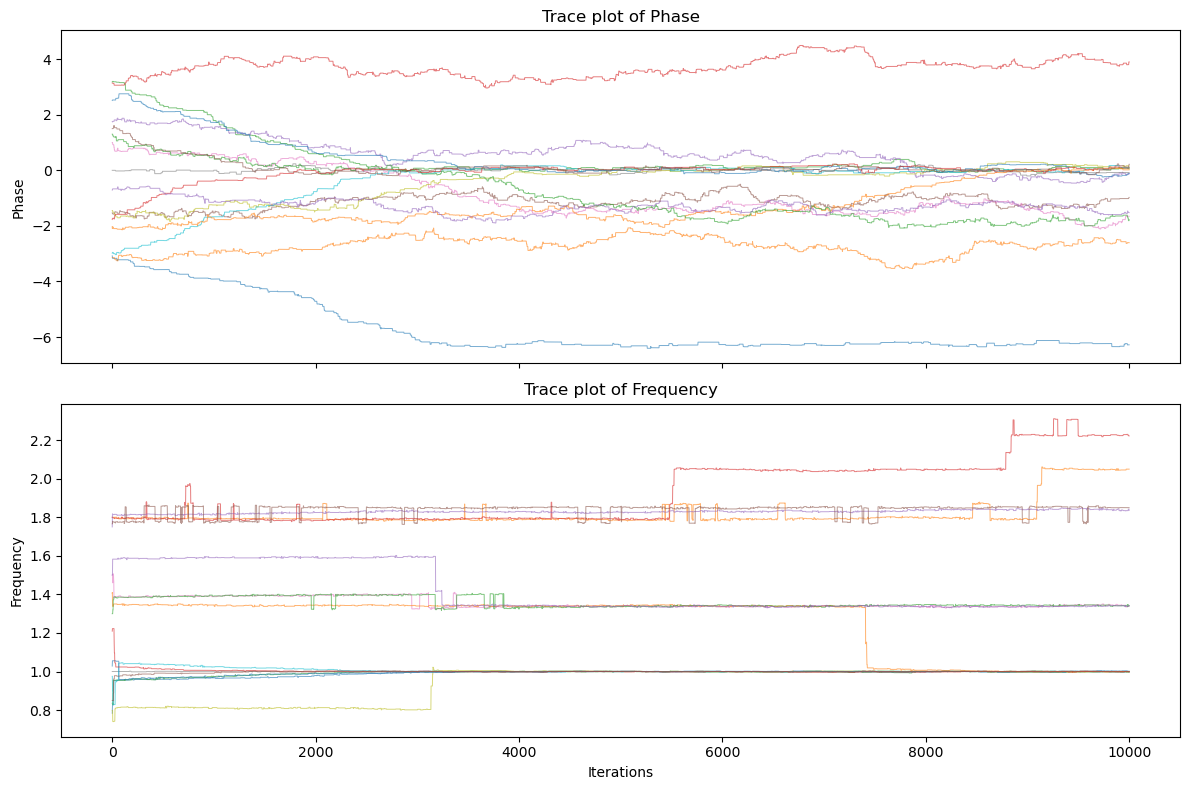

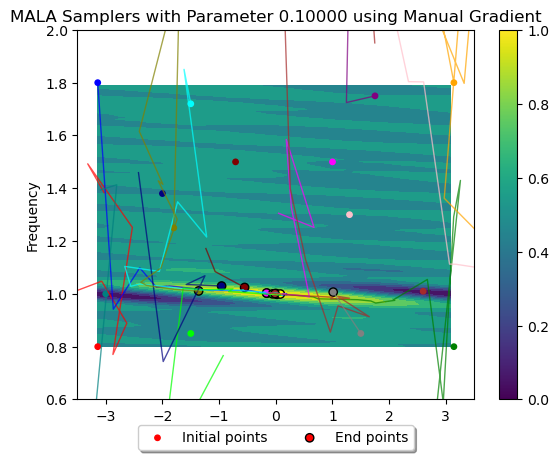

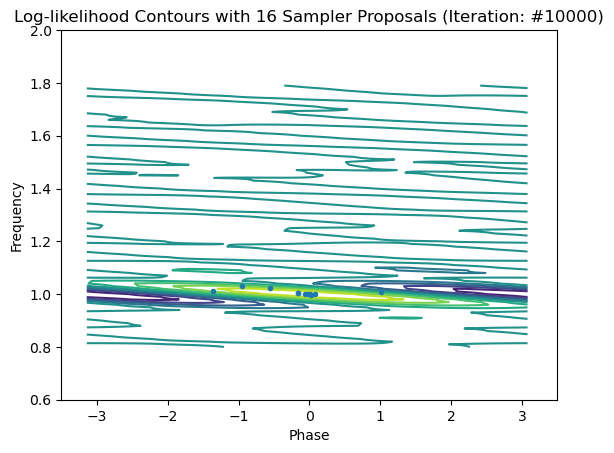

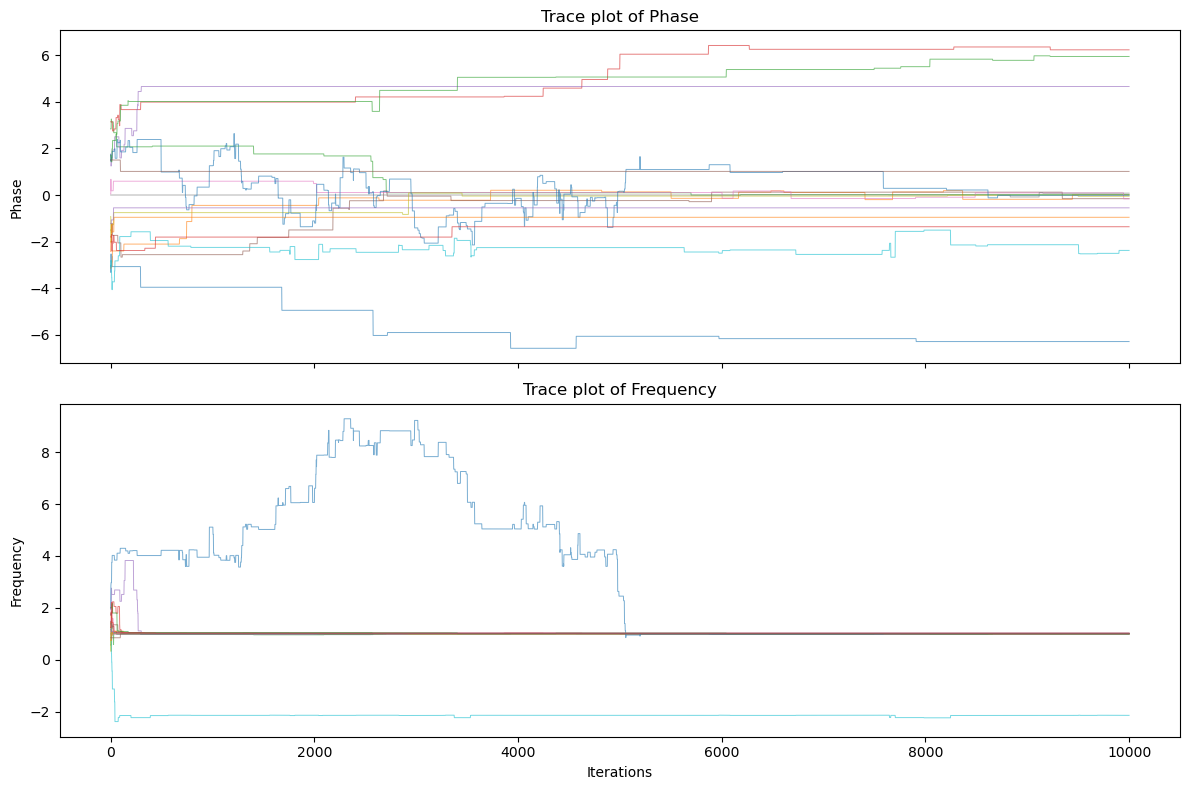

In [71]:
for i in range(len(step)):
    plt.contourf(phase_t, freq_t, loglike, 10)
    plt.scatter(x0,y0,c=colors,s=15, marker='o', label='Initial points')
    plt.scatter(values2[i][:,9999,0], values2[i][:,9999,1], color=colors, edgecolors='k',marker='o', label='End points')
    for k in range(np.array(values).shape[1]):
        plt.plot(values2[i][k, :, 0], values2[i][k, :, 1], color=colors[k], alpha=0.7, linewidth=1)
    plt.xlim([-3.5, 3.5])
    plt.ylim([0.6, 2])
    plt.xlabel('Phase')
    plt.ylabel('Frequency')
    plt.colorbar();
    plt.title('MALA Samplers with Parameter {:.5f} using Manual Gradient'.format(step[i]))
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
    plt.show()

    xp_np = np.array(values2[i][:,9999,:])
    plt.contour(phase_t, freq_t, loglike, levels=10, cmap='viridis')
    plt.plot(xp_np[:,0],xp_np[:,1],'.')
    plt.xlabel('Phase')
    plt.ylabel('Frequency')
    plt.title('Log-likelihood Contours with 16 Sampler Proposals (Iteration: #10000)')
    plt.xlim([-3.5, 3.5])
    plt.ylim([0.6, 2])
    plt.show()

    xp_np = np.array(values2[i])
    iterations = xp_np.shape[1]

    param_names = ['Phase', 'Frequency']

    fig, axes = plt.subplots(nrows=2, figsize=(12, 8), sharex=True)

    # Loop over each parameter (e.g., Phase and Frequency)
    for param_idx in range(2):
        ax = axes[param_idx]
        for chain_idx in range(xp_np.shape[0]):
            ax.plot(
                np.arange(iterations),
                xp_np[chain_idx, :, param_idx],
                alpha=0.6,
                linewidth=0.7
            )
        ax.set_ylabel(f'{param_names[param_idx]}')
        ax.set_title(f'Trace plot of {param_names[param_idx]}')
    
    axes[-1].set_xlabel('Iterations')
    
    plt.tight_layout()
    plt.show()

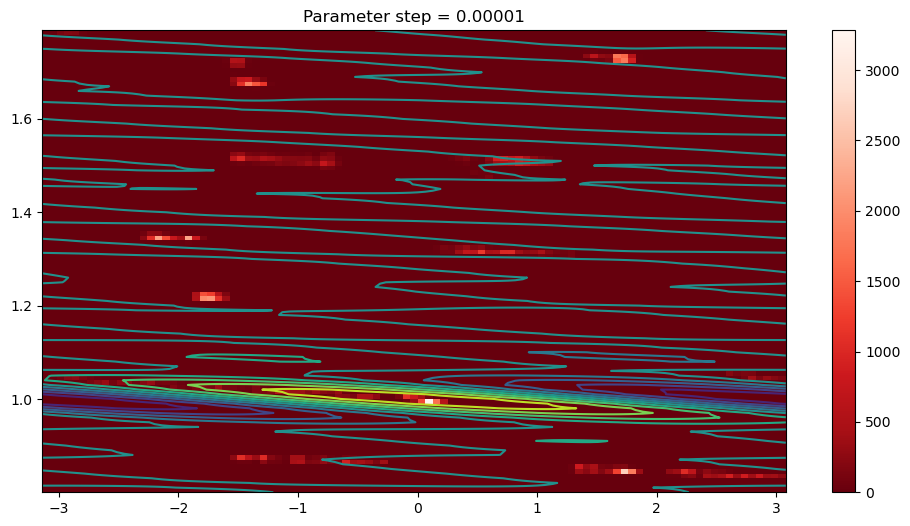

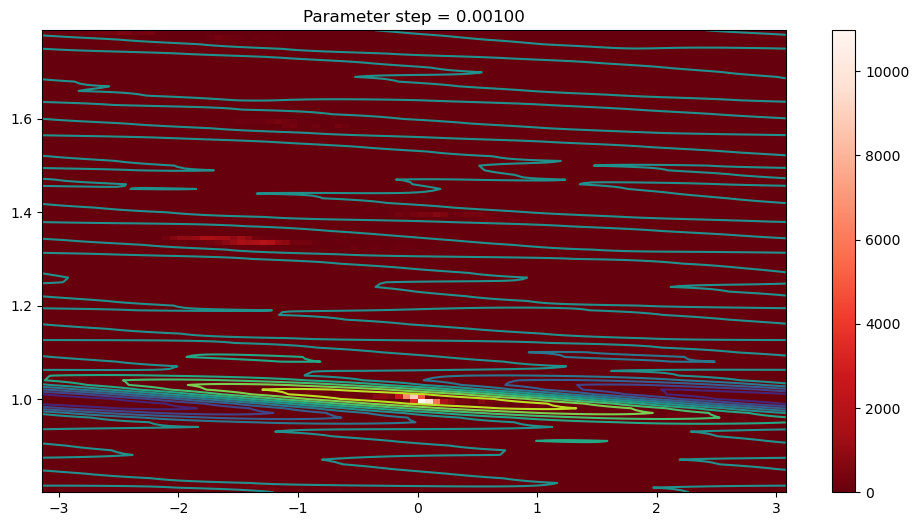

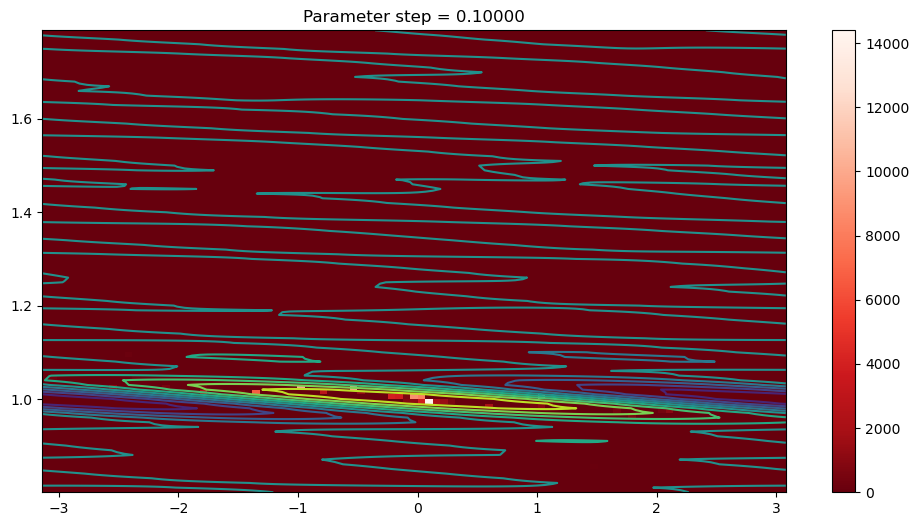

In [67]:
for i in range(len(step)):
    plt.figure(figsize=(12, 6))
    plt.contour(phase_t, freq_t, loglike, 9)
    plt.hist2d(values2[i][:,:,0].flatten(), values2[i][:,:,1].flatten(), bins=[phase_t, freq_t],cmap=plt.cm.Reds_r)
    #plt.gca().set_aspect('equal')
    # plt.xlim(-1,1)
    # plt.ylim(0.9,1.2)
    plt.title('Parameter step = {:.5f}'.format(step[i]))
    plt.colorbar();
    plt.show()

### Evaluation Metrics for MALA

In [64]:
for i in range(len(step)):
    for j in range(n_sample):
        per_accept = np.array(count2)[i][j] / chainlen * 100
        print('Given parameter step size = {:.5f}, {:.2f} % accepted overall, Time taken: {:.3f}s, \nKL Divergence: {:.4f} and ESS for x0: {:.3f}, x1: {:.3f}'
              .format(step[i], np.mean(per_accept), np.array(timetaken2)[i][j], np.array(kl_divergence2)[i][j], np.array(ess2)[i][j][0], np.array(ess2)[i][j][1]))

Given parameter step size = 0.00001, 21.23 % accepted overall, Time taken: 18.304s, 
KL Divergence: nan and ESS for x0: 5.541, x1: 10.126
Given parameter step size = 0.00001, 24.32 % accepted overall, Time taken: 17.914s, 
KL Divergence: 7.6060 and ESS for x0: 13.217, x1: 114.324
Given parameter step size = 0.00001, 19.36 % accepted overall, Time taken: 18.024s, 
KL Divergence: 6.6853 and ESS for x0: 5.464, x1: 10.643
Given parameter step size = 0.00001, 24.48 % accepted overall, Time taken: 18.277s, 
KL Divergence: 8.5574 and ESS for x0: 6.896, x1: 28.449
Given parameter step size = 0.00001, 31.70 % accepted overall, Time taken: 17.885s, 
KL Divergence: 6.8301 and ESS for x0: 6.033, x1: 27.444
Given parameter step size = 0.00001, 28.21 % accepted overall, Time taken: 18.078s, 
KL Divergence: 6.9582 and ESS for x0: 35.093, x1: 190.511
Given parameter step size = 0.00001, 31.24 % accepted overall, Time taken: 19.660s, 
KL Divergence: 6.4377 and ESS for x0: 12.508, x1: 49.965
Given param

In [69]:
np.sum(np.array(timetaken2),axis=1), np.nanmean(kl_divergence2,axis=1), np.nanmean(ess2,axis=1)

(array([305.43020058, 309.34303451, 341.11143208]),
 array([7.23436251, 6.9498113 , 8.57396858]),
 array([[ 9.62028187, 93.41388556],
        [34.19880812, 96.31260746],
        [16.57514776, 36.2505632 ]]))

In [70]:
np.mean((np.array(count2)/chainlen),axis=1)

array([0.2330875, 0.02015  , 0.00045  ])

### Gradient vector plot (for fun)

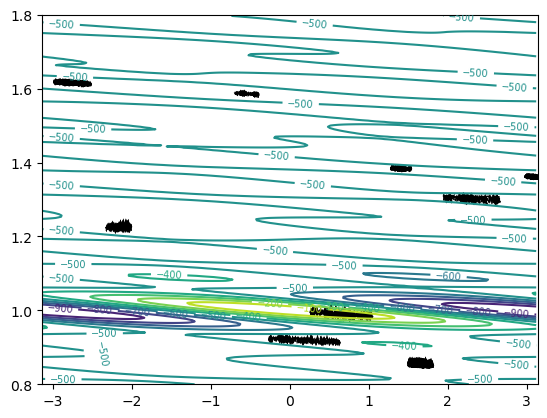

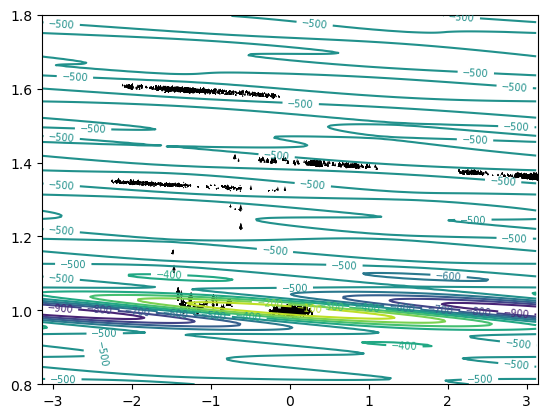

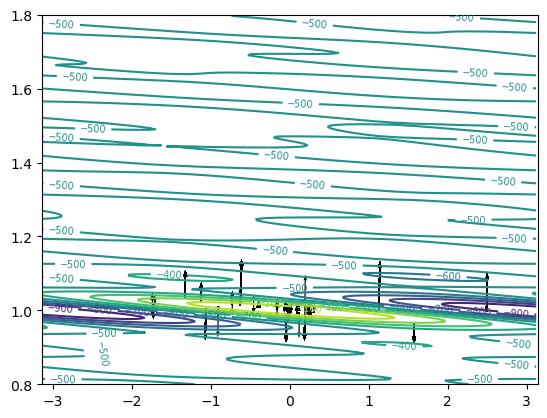

In [72]:
for i in range(len(step)):
    visual = plt.contour(phase_t, freq_t, loglike, 10)
    plt.clabel(visual, inline=True, fontsize=7)
    plt.quiver(np.array(values2)[i][:,:,0].flatten(), np.array(values2)[i][:,:,1].flatten(), np.array(grad2)[i][:,:,0].flatten(), np.array(grad2)[i][:,:,1].flatten(), scale=250)
    plt.xlim([-torch.pi,torch.pi])
    plt.ylim([0.8,1.8])
    plt.show()

# Hamiltonian Monte Carlo (HMC) Codes

In [ ]:
def out_of_range(x):
    """
    Check if the state x (a numpy array of two parameters) lies outside the allowed domain.
    Allowed domain: phase in [-pi, pi] and frequency in [0.8, 1.8].
    Returns True if x is out-of-range, and False otherwise.
    """
    phase, freq = x[0], x[1]
    if (-np.pi <= phase <= np.pi) and (0.8 <= freq <= 1.8):
        return False
    else:
        return True

# --- Define the potential energy U and its gradient for HMC ---
# Here we set U(x) = - log likelihood so that high likelihood corresponds to low potential energy.
def U(x):
    # x is a numpy array [phase, freq]
    waveform = h(t, x[0], x[1], dfreq, ddfreq)
    return -log_likelihood(template, waveform)

def grad_log_likelihood(x):
    """
    A simple numerical gradient of the log likelihood with respect to [phase, freq].
    For demonstration purposes we use finite differences here, but you may replace this
    with an analytical derivative if available.
    """
    epsilon_fd = 1e-6
    grad = np.zeros_like(x)
    for i in range(len(x)):
        x_forward = np.copy(x)
        x_backward = np.copy(x)
        x_forward[i] += epsilon_fd
        x_backward[i] -= epsilon_fd
        # Compute waveform differences
        waveform_forward = h(t, x_forward[0], x_forward[1], dfreq, ddfreq)
        waveform_backward = h(t, x_backward[0], x_backward[1], dfreq, ddfreq)
        ll_forward = log_likelihood(template, waveform_forward)
        ll_backward = log_likelihood(template, waveform_backward)
        grad[i] = (ll_forward - ll_backward) / (2 * epsilon_fd)
    return grad

def grad_U(x):
    # Since U(x) = - log likelihood, its gradient is minus that of the log likelihood.
    return -grad_log_likelihood(x)

# --- HMC iteration with 2-d epsilon and out-of-range checking ---
def hmc_iteration(U, grad_U, epsilon, L, current_q, std_dev):
    """
    One HMC iteration using a leapfrog integrator with 2-d step sizes.
    
    Parameters:
      U : callable
          The potential energy function.
      grad_U : callable
          The gradient of U.
      epsilon : np.ndarray
          A 2-d vector of step sizes (one per parameter) for the leapfrog integrator.
      L : int
          Number of leapfrog steps.
      current_q : np.ndarray
          Current state (e.g., [phase, freq]).
      std_dev : float or np.ndarray
          Standard deviation(s) for momentum sampling.
    
    Returns:
      np.ndarray
          The new state after the HMC iteration. If the proposal goes out-of-range,
          the current state is returned.
    """
    q = np.copy(current_q)
    # Sample momentum from a zero-mean Gaussian with the specified std_dev (can be scalar or vector)
    p = np.random.normal(loc=0, scale=std_dev, size=q.shape)
    current_p = np.copy(p)
    
    # Leapfrog integration: initial half-step for momentum
    p = p - (epsilon * grad_U(q)) / 2
    
    # Leapfrog integration: full steps
    for i in range(L):
        # Update position using element-wise multiplication for 2-d step sizes
        q = q + epsilon * p
        # Check if the new q is within allowed range; if not, deem the trajectory divergent.
        # if out_of_range(q):
        #     return current_q
        # Update momentum except on the last iteration
        if i != L - 1:
            p = p - epsilon * grad_U(q)
    
    # Final half-step update for momentum
    p = p - epsilon * grad_U(q)
    # if out_of_range(q):  # double-check final state is in range
    #     return current_q
    
    # Negate momentum to make the proposal symmetric
    p = -p

    # Compute energies at current and proposed states
    current_U_val = U(current_q)
    current_K = np.sum(current_p**2) / 2
    proposed_U_val = U(q)
    proposed_K = np.sum(p**2) / 2

    # Metropolis acceptance step
    if np.random.rand() < np.exp(current_U_val - proposed_U_val + current_K - proposed_K):
        return q
    else:
        return current_q

# --- HMC sampler following the style of your RWM and MALA samplers ---
def hmc_toy(hist_0, x_edges, y_edges, chainlen, Z0, epsilon, L, std_dev):
    """
    Run HMC chains on the toy model.

    Parameters:
      hist_0 : 2D histogram (reference density) for KL divergence calculation.
      x_edges, y_edges : Bin edges for histogramming samples.
      chainlen : Number of iterations per chain.
      Z0 : Initial samples (array of shape (n_sample, 2)).
      epsilon : A 2-d vector of leapfrog step sizes (one per parameter).
      L : Number of leapfrog steps per iteration.
      std_dev : Standard deviation for momentum sampling.

    Returns:
      timetaken : List of run times (one per chain).
      count : List of acceptance counts (post burn-in) for each chain.
      samples : Array of samples (post burn-in) for each chain.
      kl_divergence : List of KL divergence values (one per chain).
      ess : List of effective sample sizes (one per chain).
    """
    count = []
    sample1 = []
    timetaken = []
    kl_divergence = []
    ess = []
    burnin = int(chainlen / 2)

    for i in range(len(Z0)):
        tic = time.time()
        Zi = [Z0[i]]  # starting point for chain i
        counts = 0
        for j in tqdm(range(chainlen), desc=f"HMC chain {i+1}/{len(Z0)}"):
            x = Zi[j]
            new_x = hmc_iteration(U, grad_U, epsilon, L, x, std_dev)
            # If the proposal equals the current state, we consider it rejected.
            accept = 0 if np.array_equal(new_x, x) else 1
            counts += accept
            Zi.append(new_x)
        sample1.append(Zi)
        count.append(counts)
        timetaken.append(time.time() - tic)
        
        # Compute histogram of post-burnin samples for KL divergence
        chain_array = np.array(Zi[burnin:])  # shape: (chainlen-burnin+1, 2)
        hist_A, _, _ = np.histogram2d(chain_array[:, 0], chain_array[:, 1],
                                      bins=[x_edges, y_edges], density=True)
        prob_A = hist_A / np.sum(hist_A)
        prob_0 = hist_0 / np.sum(hist_0)
        prob_A_flat = prob_A.flatten() + 1e-10
        prob_0_flat = prob_0.flatten() + 1e-10
        kl_div = entropy(prob_A_flat, prob_0_flat)
        kl_divergence.append(kl_div)
        
        # Compute effective sample size for each dimension
        ess_chain = np.array([neff(chain_array[:, k]) for k in range(2)])
        ess.append(ess_chain)
    
    samples = np.array([np.array(chain) for chain in sample1])
    return timetaken, count, samples, kl_divergence, ess

## This is the general code for execution, plot and evaluation metric

In [ ]:
L = 10           # number of leapfrog steps per iteration
std_dev = 1.0    # momentum standard deviation

# List of different 2-d epsilon values to test
epsilon_list = [
    np.array([0.01, 0.005]),
    np.array([0.001, 0.0005]),
    np.array([0.1, 0.02])
]

# Loop over different epsilon values
for eps in epsilon_list:
    # Run the HMC sampler for current epsilon vector
    timetaken, count, samples, kl_div, ess = hmc_toy(hist_0, x_edges, y_edges, chainlen, Z0, eps, L, std_dev)

    # Plot the contour of the target density and overlay the HMC samples (post burn-in)
    plt.contourf(phase_t, freq_t, loglike, 10)
    # plt.clabel(visual, inline=True, fontsize=7)
    plt.scatter(x0,y0,c=colors,s=15, marker='o', label='Initial points')
    plt.scatter(samples[:,10000,0], samples[:,10000,1], color=colors, edgecolors='k',marker='o', label='End points')
    for k in range(np.array(samples).shape[0]):
        plt.plot(samples[k, :, 0], samples[k, :, 1], color=colors[k], alpha=0.7, linewidth=1)
    plt.xlim([-3.5, 3.5])
    plt.ylim([0.6, 2])
    plt.xlabel('Phase')
    plt.ylabel('Frequency')
    plt.colorbar();
    plt.title('HMC Samples with epsilon = [{:.5f}, {:.5f}] and L = {}'.format(eps[0], eps[1], L))
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
    plt.show()

    xp_np = np.array(samples[:,10000,:])
    plt.contour(phase_t, freq_t, loglike, levels=10, cmap='viridis')
    plt.plot(xp_np[:,0],xp_np[:,1],'.')
    plt.xlabel('Phase')
    plt.ylabel('Frequency')
    plt.title('Log-likelihood Contours with 16 Sampler Proposals (Iteration: #10000)')
    plt.xlim([-3.5, 3.5])
    plt.ylim([0.6, 2])
    plt.show()
    
    # Plot the contour of the target density and overlay the HMC samples (post burn-in)
    plt.contourf(phase_t, freq_t, loglike, 10)
    plt.scatter(x0,y0,c=colors,s=15, marker='o', label='Initial points')
    plt.scatter(samples[:,10000,0], samples[:,10000,1], color=colors, edgecolors='k',marker='o', label='End points')
    for k in range(np.array(samples).shape[0]):
        plt.plot(samples[k, :, 0], samples[k, :, 1], color=colors[k], alpha=0.7, linewidth=1)
    plt.xlabel('Phase')
    plt.ylabel('Frequency')
    plt.colorbar();
    plt.title('HMC Samples with epsilon = [{:.5f}, {:.5f}] and L = {}'.format(eps[0], eps[1], L))
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
    plt.show()

    xp_np = np.array(samples[:,10000,:])
    plt.contour(phase_t, freq_t, loglike, levels=10, cmap='viridis')
    plt.plot(xp_np[:,0],xp_np[:,1],'.')
    plt.title('Log-likelihood Contours with 16 Sampler Proposals (Iteration: #10000)')
    plt.xlim([-3.5, 3.5])
    plt.ylim([0.6, 2])
    plt.show()

    xp_np = np.array(samples)
    iterations = xp_np.shape[1]

    param_names = ['Phase', 'Frequency']

    fig, axes = plt.subplots(nrows=2, figsize=(12, 8), sharex=True)

    # Loop over each parameter (e.g., Phase and Frequency)
    for param_idx in range(2):
        ax = axes[param_idx]
        for chain_idx in range(xp_np.shape[0]):
            ax.plot(
                np.arange(iterations),
                xp_np[chain_idx, :, param_idx],
                alpha=0.6,
                linewidth=0.7
            )
        ax.set_ylabel(f'{param_names[param_idx]}')
        ax.set_title(f'Trace plot of {param_names[param_idx]}')
    
    axes[-1].set_xlabel('Iterations')
    plt.tight_layout()
    plt.show()

        
    plt.figure(figsize=(12, 6))
        
    plt.contour(phase_t, freq_t, loglike, 9)
    plt.hist2d(samples[:,:,0].flatten(), samples[:,:,1].flatten(), bins=[phase_t, freq_t],cmap=plt.cm.Reds_r)
    #plt.gca().set_aspect('equal')
    # plt.xlim(-1,1)
    # plt.ylim(0.9,1.2)
    plt.title('Parameter epsilon = [{:.5f}, {:.5f}] and L = {}'.format(eps[0], eps[1], L))
    plt.colorbar();
    plt.show()
    
    # Print metrics for each chain for this epsilon value
    print("Results for epsilon = [{:.5f}, {:.5f}]".format(eps[0], eps[1]))
    for i in range(len(count)):
        per_accept = count[i] / chainlen * 100  # acceptance percentage
        print('Chain {}: Acceptance ratio: {:.2f}% | Time taken: {:.3f}s'.format(
            i+1, per_accept, timetaken[i]))
        print('         KL Divergence: {:.4f} | ESS: phase = {:.3f}, freq = {:.3f}'.format(
            kl_div[i], ess[i][0], ess[i][1]))
    print("-" * 70)

    print(np.sum(np.array(timetaken)), np.nanmean(kl_div), np.nanmean(ess, axis=0))
    print(np.mean((np.array(count)/chainlen)))

# Learning 2 Hamiltonian Monte Carlo (L2HMC) Codes

In [1]:
#import torch
import numpy as np
from scipy.stats import multivariate_normal, ortho_group
ortho_group.rvs(2)

array([[-0.76609878, -0.64272285],
       [ 0.64272285, -0.76609878]])

In [2]:
import sys
sys.path.insert(0, 'utils/')

In [11]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device = "cpu"
device

'cpu'

In [12]:
from func_utils_pt import acl_spectrum, ESS
from distributions_pt import Moon, toy
from layers_pt import Net
from dynamics_pt import Dynamics
from sampler_pt import propose
from notebook_utils_pt import get_hmc_samples, plot_gaussian_contours

In [13]:
# Color definition for plots
c_l2hmc, c_hmc1, c_hmc2, c_hmc3 = 'blue', 'orange', 'green', 'red'
c_true, c_contour = 'purple', '0.75'

In [14]:
network = Net
x_dim = 2

# Toy model from distributions_pt module
dist = toy(template, t, phase, freq, dfreq, ddfreq, device=device)

In [17]:
def neural_train(n_steps, n_samples, dynamics, x_dim, device, use_barker=False):
    scale = torch.tensor(0.1, device=device)
    
    optim = Adam(dynamics.parameters())
    scheduler = StepLR(optim, step_size=1000, gamma=0.96)
    dynamics.alpha
    def criterion(v1, v2):
        return scale * (torch.mean(1.0 / v1) + torch.mean(1.0 / v2)) + (-torch.mean(v1) - torch.mean(v2)) / scale
    
    for t in tqdm(range(n_steps)):    
        if(t==0):
            #x = torch.randn(n_samples, x_dim, dtype=torch.float32, device=device)
            xy_min = [-torch.pi,0.8]
            xy_max = [torch.pi,1.8]
            #x = torch.tensor(np.random.uniform(low=xy_min, high=xy_max, size=(n_samples,x_dim)), dtype=torch.float32, device=device)
            #x = (0.8 - 1.8)*torch.rand(n_samples, x_dim, dtype=torch.float32, device=device) + 1.8
            x = torch.tensor(np.array([x0,y0]),device=device).T
            
        else:
            x = output[0]
    
        z = torch.randn_like(x, dtype=torch.float32, device=device)
        
        optim.zero_grad()
        Lx, _, log_px, output, _, _ = propose(x, dynamics, do_mh_step=True, device=device, use_barker=use_barker)
        Lz, _, log_pz, _, _, _ = propose(z, dynamics, do_mh_step=False, device=device, use_barker=use_barker)
        
        if use_barker:
            px = log_px[0].exp()
            pz = log_pz[0].exp()
        else:
            px = log_px.exp()
            pz = log_pz.exp()
        
    
        v1 = (torch.sum((x - Lx)**2, dim=1) * px) + torch.tensor(1e-4, dtype=torch.float32, device=device)
        v2 = (torch.sum((z - Lz)**2, dim=1) * pz) + torch.tensor(1e-4, dtype=torch.float32, device=device)
        scale = torch.tensor(0.1, dtype=torch.float32, device=device)
    
        loss = criterion(v1, v2)
        loss.backward()
    
        optim.step()
    #     pdb.set_trace()
    
        if t % 1000 == 0 or t == n_steps-1:
            current_lr = None
            for param_group in optim.param_groups:
                current_lr = param_group['lr']
            print ('Step: %d / %d, Loss: %.2e, Acceptance sample: %.2f, LR: %.5f' % (t, n_steps, loss.item(), np.mean(px.cpu().detach().numpy()), current_lr))
        scheduler.step()
        optim.zero_grad()
    dynamics.alpha

In [18]:
def l2hmc_toy(hist_0, x_edges, y_edges, chainlen, Z0, x_dim, n_sample, dist, T, eps, network, device, hmc=False):
    timetaken = []
    half_step = int(chainlen/2)
    kl_divergence = []
    ess = []

    print("T = {}, eps = {}".format(T, eps))
    if not hmc:
        dynamics = Dynamics(x_dim, dist.get_energy_function(), dist.manual_grad_log_likelihood(), T, eps, hmc=False, net_factory=network, use_temperature=True, device=device)
        neural_train(int(half_step/2), 512, dynamics, x_dim, device=device)
    else:
        dynamics = Dynamics(x_dim, dist.get_energy_function(), dist.manual_grad_log_likelihood(), T, eps, hmc=True, use_temperature=True, device=device) 
    
    #samples = torch.tensor(Z0, dtype=torch.float32, device=device)
    samples = torch.tensor(np.array([x0,y0]),device=device).T
    final_samples = []

    samples_ = samples
    tic = time.time()
    
    with torch.no_grad():
    #     pdb.set_trace()
        for t in tqdm(range(chainlen)):
            final_samples.append(samples_.cpu().numpy())
            if not hmc:
                _, _, log_px, samples_, _, _ = propose(samples_, dynamics, do_mh_step=True, device=device)
                samples_ = samples_[0].detach()
            else:
                _, _, log_px, samples_ = propose(samples_, dynamics, do_mh_step=True, device=device)
                samples_ = samples_[0][0].detach()
    timetaken = time.time() - tic
    accept = log_px.exp()

    samples = np.array(final_samples)
    final_samples = np.array(final_samples[half_step:])

    k, l, m = final_samples.shape
    for i in range(n_sample):
        hist_A, _, _ = np.histogram2d(final_samples[:,i,0], final_samples[:,i,1], bins=[x_edges, y_edges], density=True)

        prob_A = hist_A / np.sum(hist_A)
        prob_0 = hist_0 / np.sum(hist_0)
    
        prob_A_flat = prob_A.flatten()
        prob_0_flat = prob_0.flatten()
    
        epsilon = 1e-10
        prob_A_flat += epsilon
        prob_0_flat += epsilon

        kl_divergenced = entropy(prob_A_flat, prob_0_flat)
        kl_divergence.append(kl_divergenced)
    
    ess0 = np.array([[neff(final_samples[:,i,j]) for j in range(2)] for i in range(n_sample)])
    ess.append(ess0)
    
    return timetaken, np.mean(accept.cpu().detach().numpy()), samples, kl_divergence, ess

In [19]:
#T = np.array([5,2,1])
T = np.array([15])
#eps = np.array([1,0.5,0.1,0.005,0.001,0.00005,0.00001])

eps = np.array([[0.01,0.005],[0.001,0.0005],[0.1,0.02]])

timetaken3 = []
accept3 = []
sample3 = []
kl_divergence3 = []
ess3 = []

for i in range(len(T)):
    for j in range(len(eps)):
        #if T[i] < 5 or ((T[i] == 5 and eps[j] < 0.5) or (T[i] == 10 and eps[j] == 0.1)):
            tt, x, y, z, e= l2hmc_toy(np.array(loglike), x_edges, y_edges, chainlen, Z0, x_dim, n_sample, dist, T[i], eps[j], network, device)
            timetaken3.append(tt)
            accept3.append(x)
            sample3.append(y)
            kl_divergence3.append(z)
            ess3.append(e)

T = 15, eps = [0.01  0.005]


C:\Users\justi\Thesis\utils3\dynamics_pt.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Temp = torch.tensor(self.temperature, dtype=torchType, device=device)
  0%|                                                                                 | 1/2500 [00:00<15:08,  2.75it/s]

Step: 0 / 2500, Loss: 3.42e+02, Acceptance sample: 0.31, LR: 0.00100


 40%|███████████████████████████████▏                                              | 1001/2500 [05:10<08:05,  3.09it/s]

Step: 1000 / 2500, Loss: 1.12e+03, Acceptance sample: 0.00, LR: 0.00096


 80%|██████████████████████████████████████████████████████████████▍               | 2001/2500 [10:24<02:35,  3.21it/s]

Step: 2000 / 2500, Loss: 1.03e+03, Acceptance sample: 0.00, LR: 0.00092


100%|██████████████████████████████████████████████████████████████████████████████| 2500/2500 [13:15<00:00,  3.14it/s]


Step: 2499 / 2500, Loss: 1.06e+03, Acceptance sample: 0.00, LR: 0.00092


100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [11:17<00:00, 14.76it/s]
C:\Users\justi\anaconda3\Lib\site-packages\numpy\lib\histograms.py:1067: RuntimeWarning: invalid value encountered in divide
  hist /= s
C:\Users\justi\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:691: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]
C:\Users\justi\Thesis\utils3\dynamics_pt.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Temp = torch.tensor(self.temperature, dtype=torchType, device=device)


T = 15, eps = [0.001  0.0005]


  0%|                                                                                 | 1/2500 [00:00<12:52,  3.23it/s]

Step: 0 / 2500, Loss: 1.20e+03, Acceptance sample: 0.08, LR: 0.00100


 40%|███████████████████████████████▏                                              | 1001/2500 [05:30<08:03,  3.10it/s]

Step: 1000 / 2500, Loss: 1.12e+02, Acceptance sample: 0.00, LR: 0.00096


 80%|██████████████████████████████████████████████████████████████▍               | 2001/2500 [10:59<02:58,  2.80it/s]

Step: 2000 / 2500, Loss: 8.92e+02, Acceptance sample: 0.00, LR: 0.00092


100%|██████████████████████████████████████████████████████████████████████████████| 2500/2500 [13:55<00:00,  2.99it/s]


Step: 2499 / 2500, Loss: 3.01e+02, Acceptance sample: 0.00, LR: 0.00092


100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [13:28<00:00, 12.38it/s]


T = 15, eps = [0.1  0.02]


  0%|                                                                                 | 1/2500 [00:00<14:39,  2.84it/s]

Step: 0 / 2500, Loss: 4.93e+02, Acceptance sample: 0.06, LR: 0.00100


 40%|███████████████████████████████▏                                              | 1001/2500 [06:54<09:12,  2.71it/s]

Step: 1000 / 2500, Loss: 7.80e+02, Acceptance sample: 0.00, LR: 0.00096


 80%|██████████████████████████████████████████████████████████████▍               | 2001/2500 [14:03<03:58,  2.09it/s]

Step: 2000 / 2500, Loss: 6.66e+02, Acceptance sample: 0.16, LR: 0.00092


100%|██████████████████████████████████████████████████████████████████████████████| 2500/2500 [18:05<00:00,  2.30it/s]


Step: 2499 / 2500, Loss: 1.27e+03, Acceptance sample: 0.00, LR: 0.00092


100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [13:34<00:00, 12.27it/s]


In [20]:
np.array(sample3).shape, np.array(sample3).shape[1]
#np.array(sample3)[0,0, min:max,0]
#for k in range(np.array(sample3).shape[1]):
#    plt.plot(sample3[counter-1,k, min:max, 0], sample3[counter-1, k, min:max, 1], color=colors[k], alpha=0.7, linewidth=1)

((3, 10000, 16, 2), 10000)

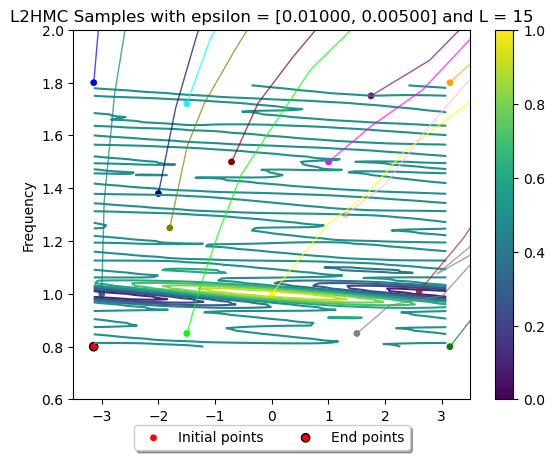

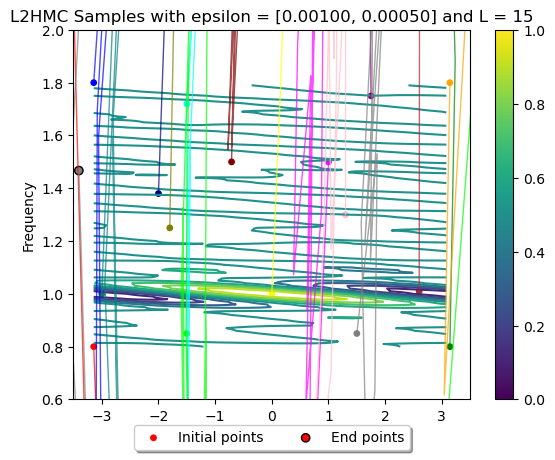

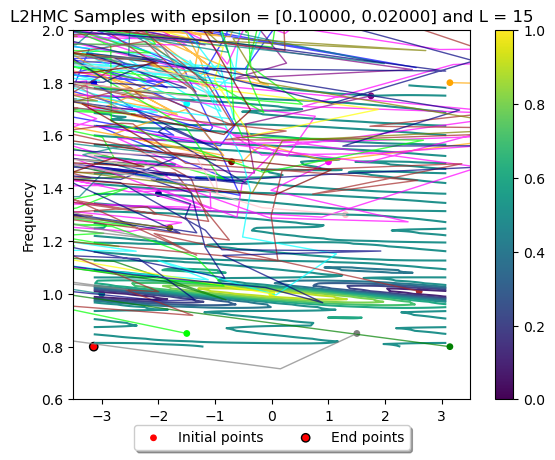

In [22]:
counter = 0
for i in range(len(T)):
    for j in range(len(eps)):
        counter += 1
        plt.contour(phase_t, freq_t, loglike, 10)
        #plt.clabel(visual, inline=True, fontsize=7)
        plt.scatter(x0,y0,c=colors,s=15, marker='o', label='Initial points')
        plt.scatter(sample3[counter-1][9999,:,0], sample3[counter-1][9999,:,1], color=colors, edgecolors='k',marker='o', label='End points')
        for k in range(np.array(sample3).shape[2]):
            plt.plot(sample3[counter-1][:, k, 0], sample3[counter-1][:, k, 1], color=colors[k], alpha=0.7, linewidth=1)
        #plt.plot(sample3[counter-1][:,min:max,0].flatten(), sample3[counter-1][:,min:max,1].flatten(), '.', alpha=0.6)
        plt.xlim([-3.5, 3.5])
        plt.ylim([0.6, 2])
        plt.xlabel('Phase')
        plt.ylabel('Frequency')
        plt.colorbar();
        plt.title('L2HMC Samples with epsilon = [{:.5f}, {:.5f}] and L = {}'.format(eps[j][0], eps[j][1], T[i]))
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
        plt.show()

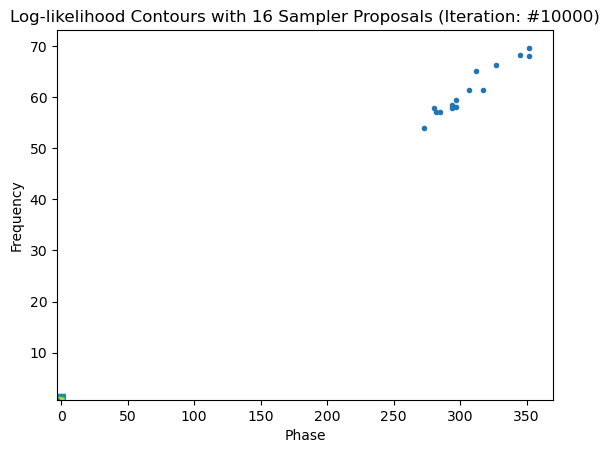

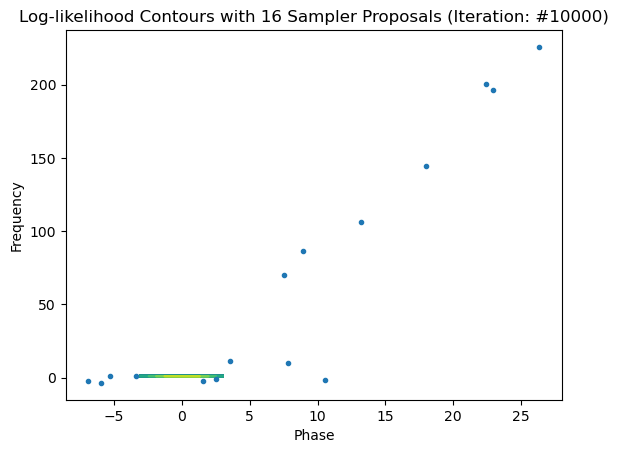

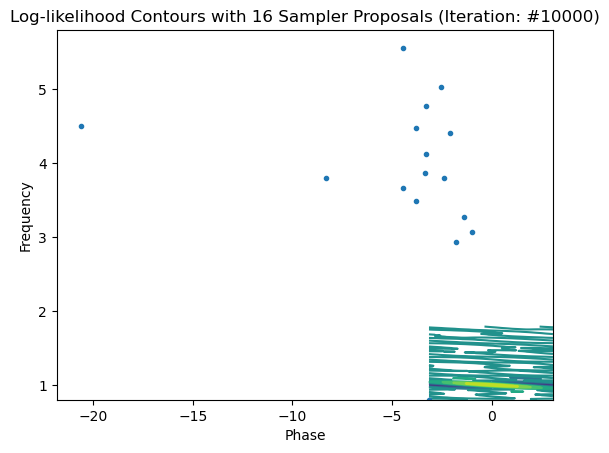

In [23]:
counter = 0
for i in range(len(T)):
    for j in range(len(eps)):
        counter += 1
        xp_np = np.array(sample3[counter-1][9999,:,:])
        plt.contour(phase_t, freq_t, loglike, levels=10, cmap='viridis')
        plt.plot(xp_np[:,0],xp_np[:,1],'.')
        plt.xlabel('Phase')
        plt.ylabel('Frequency')
        plt.title('Log-likelihood Contours with 16 Sampler Proposals (Iteration: #10000)')
        #plt.xlim([-3.5, 3.5])
        #plt.ylim([0.6, 2])
        plt.show()

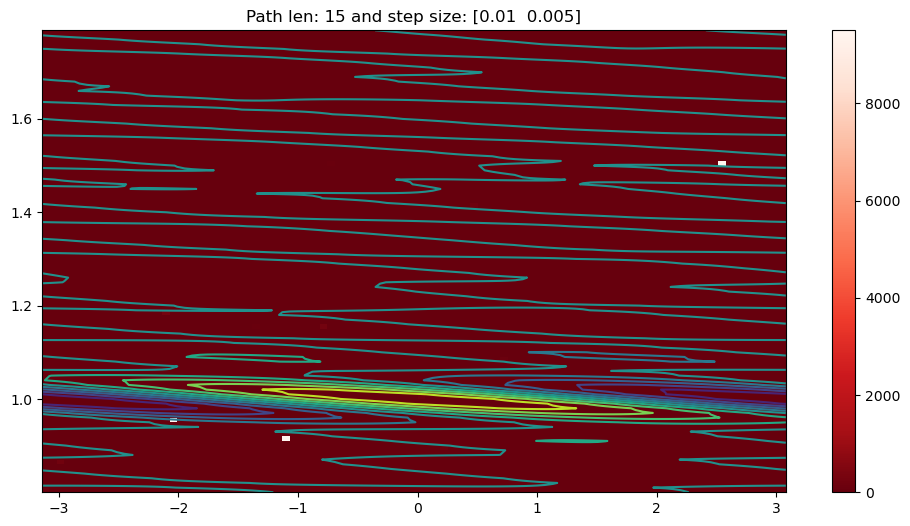

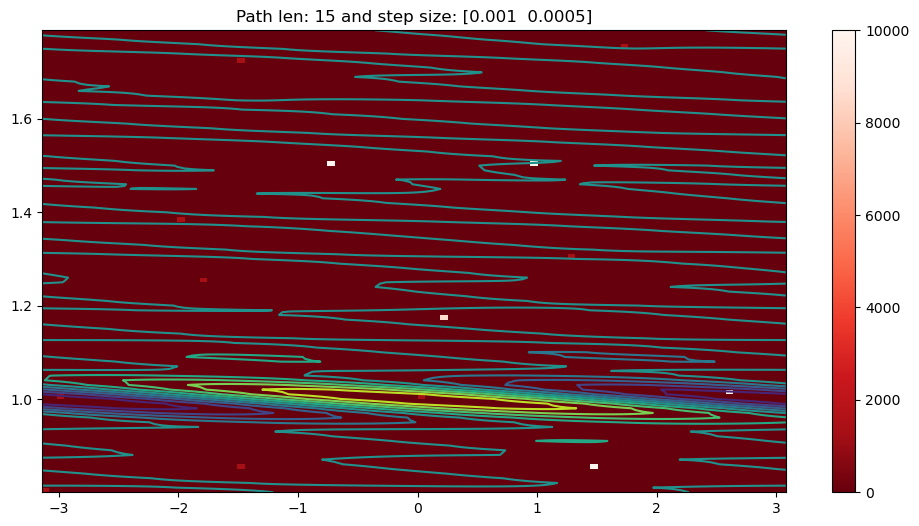

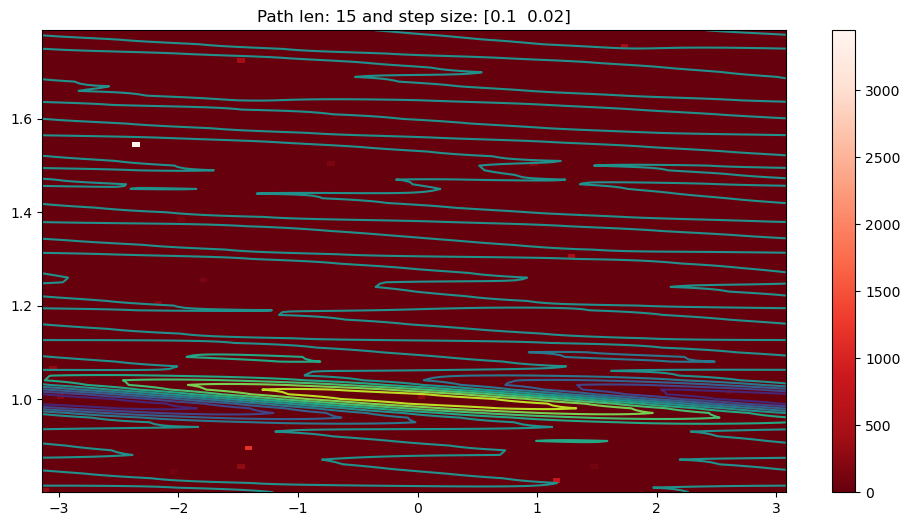

In [23]:
counter = 0
for i in range(len(T)):
    for j in range(len(eps)):
        counter += 1
        plt.figure(figsize=(12, 6))
        
        plt.contour(phase_t, freq_t, loglike, 9)
        plt.hist2d(sample3[counter-1][:,:,0].flatten(), sample3[counter-1][:,:,1].flatten(), bins=[phase_t,freq_t],cmap=plt.cm.Reds_r)
        plt.title('Path len: {:.0f} and step size: {}'.format(T[i], eps[j]))
        plt.colorbar();
        plt.show()

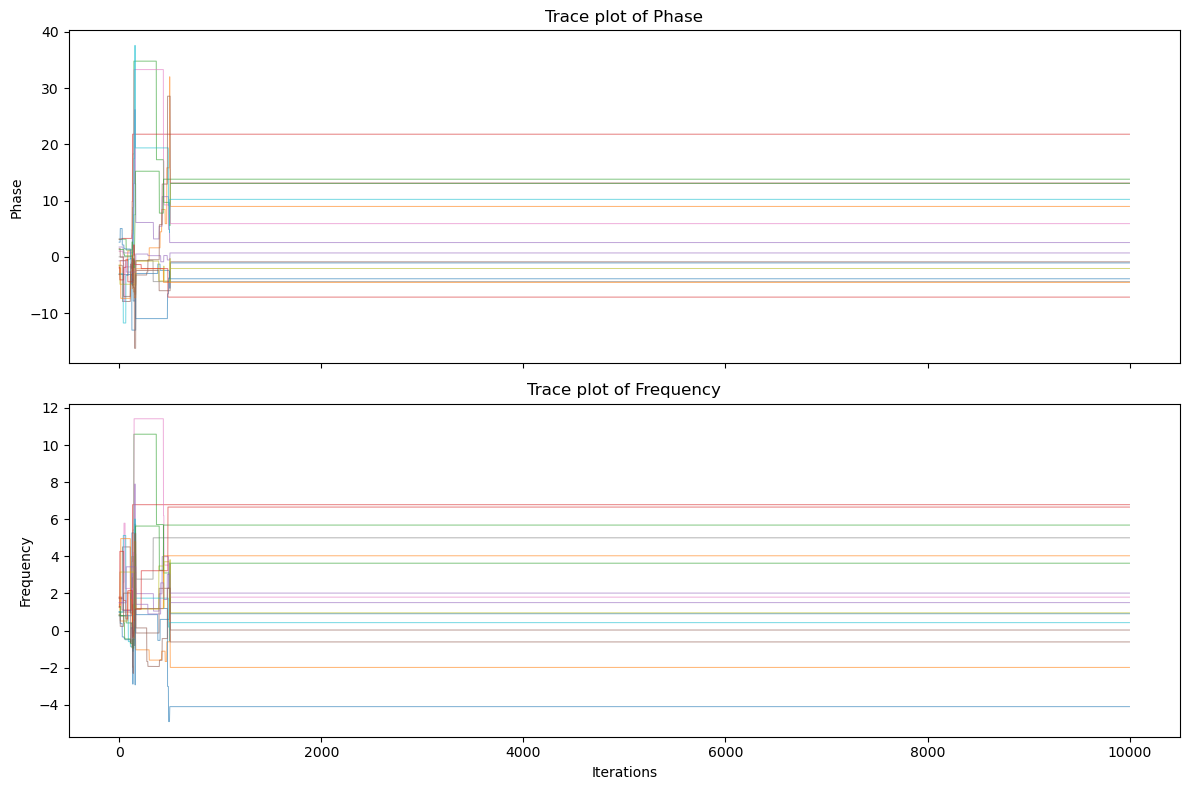

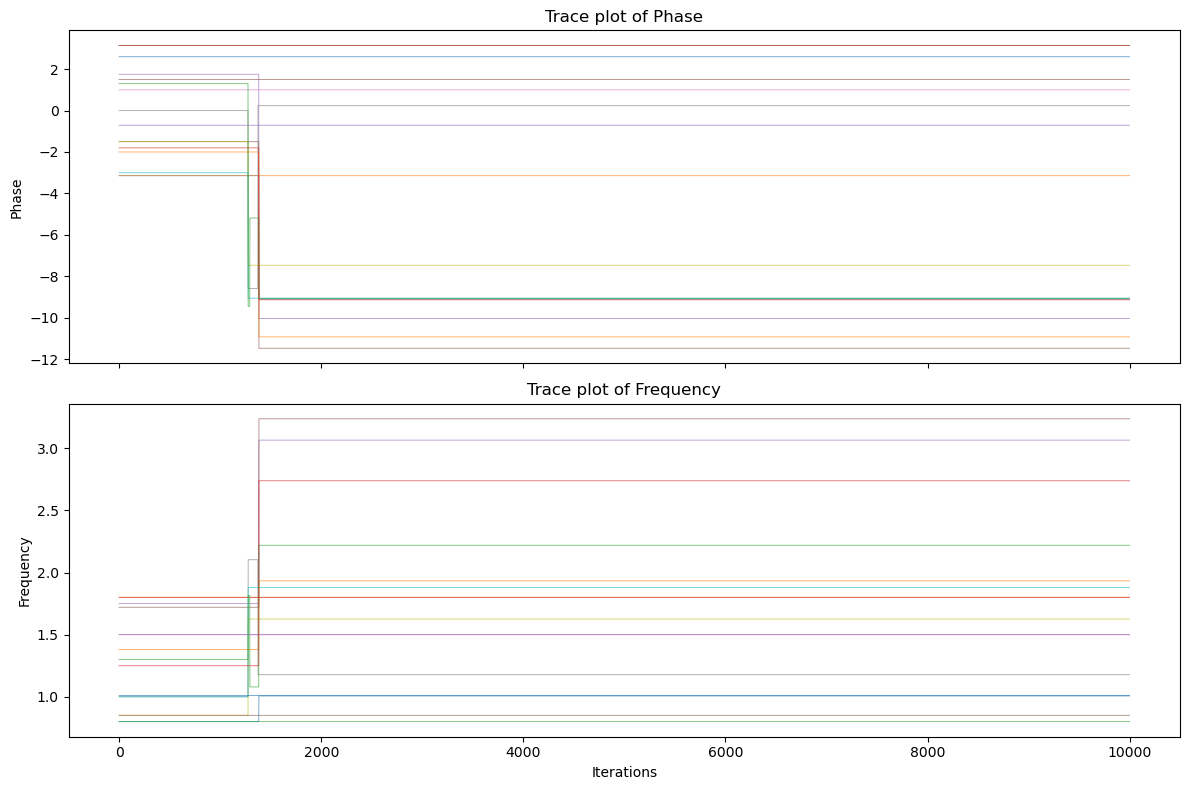

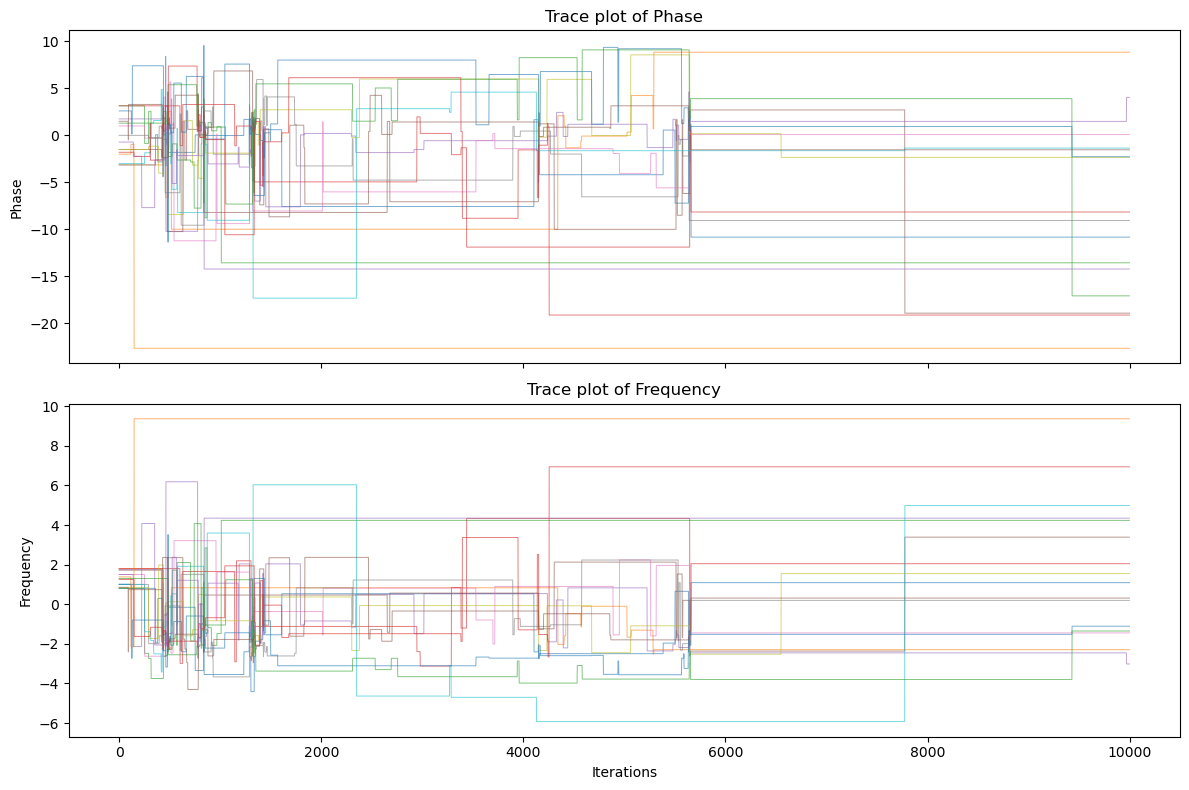

In [24]:
counter = 0
for i in range(len(T)):
    for j in range(len(eps)):
        counter += 1
        xp_np = np.array(sample3[counter-1])
        iterations = xp_np.shape[0]

        param_names = ['Phase', 'Frequency']

        fig, axes = plt.subplots(nrows=2, figsize=(12, 8), sharex=True)

        # Loop over each parameter (e.g., Phase and Frequency)
        for param_idx in range(2):
            ax = axes[param_idx]
            for chain_idx in range(xp_np.shape[1]):
                ax.plot(
                    np.arange(iterations),
                    xp_np[:, chain_idx, param_idx],
                    alpha=0.6,
                    linewidth=0.7
                )
            ax.set_ylabel(f'{param_names[param_idx]}')
            ax.set_title(f'Trace plot of {param_names[param_idx]}')
        
        axes[-1].set_xlabel('Iterations')
        
        plt.tight_layout()
        plt.show()

### Evaluation Metrics for L2HMC

In [25]:
counter = 0
for i in range(len(T)):
    for j in range(len(eps)):
        counter += 1
        for k in range(n_sample):
            per_accept = np.array(accept3[counter-1]*100)
            print('Given parameter path = {}, and eps = {}, {:.2f} % accepted overall, Time taken: {:.3f}s, \nKL Divergence: {:.4f} and ESS for x0: {:.3f}, x1: {:.3f}'
                  .format(T[i], eps[j], np.mean(per_accept), np.array(timetaken3)[counter-1], np.array(kl_divergence3)[counter-1][k], np.array(ess3)[counter-1][0][k][0], np.array(ess3)[counter-1][0][k][1]))

Given parameter path = 15, and eps = [0.01  0.005], 0.00 % accepted overall, Time taken: 739.026s, 
KL Divergence: 9.2462 and ESS for x0: nan, x1: nan
Given parameter path = 15, and eps = [0.01  0.005], 0.00 % accepted overall, Time taken: 739.026s, 
KL Divergence: nan and ESS for x0: nan, x1: nan
Given parameter path = 15, and eps = [0.01  0.005], 0.00 % accepted overall, Time taken: 739.026s, 
KL Divergence: nan and ESS for x0: nan, x1: nan
Given parameter path = 15, and eps = [0.01  0.005], 0.00 % accepted overall, Time taken: 739.026s, 
KL Divergence: nan and ESS for x0: nan, x1: nan
Given parameter path = 15, and eps = [0.01  0.005], 0.00 % accepted overall, Time taken: 739.026s, 
KL Divergence: 9.1888 and ESS for x0: nan, x1: nan
Given parameter path = 15, and eps = [0.01  0.005], 0.00 % accepted overall, Time taken: 739.026s, 
KL Divergence: nan and ESS for x0: nan, x1: nan
Given parameter path = 15, and eps = [0.01  0.005], 0.00 % accepted overall, Time taken: 739.026s, 
KL Div

In [26]:
np.array(timetaken3), np.nanmean(kl_divergence3,axis=1), np.nanmean(ess3,axis=2)

C:\Users\justi\AppData\Local\Temp\ipykernel_20264\2778754230.py:1: RuntimeWarning: Mean of empty slice
  np.array(timetaken3), np.nanmean(kl_divergence3,axis=1), np.nanmean(ess3,axis=2)


(array([739.02585149, 709.9430964 , 699.58649683]),
 array([9.05829879, 9.22521367, 9.27936043]),
 array([[[        nan,         nan]],
 
        [[        nan,         nan]],
 
        [[14.90345299, 16.43647267]]]))

In [27]:
np.array(accept3)*100

array([2.1411970e-05, 1.3293861e-35, 2.0591333e-10], dtype=float32)

# HMC Code with Neural Switched Off (Optional)

In [30]:
T = np.array([25])

#eps = np.array([1,0.5,0.1,0.005,0.001,0.00005,0.00001])

eps = np.array([[0.001,0.0005],[0.01,0.005],[0.1,0.05]])

timetaken4 = []
accept4 = []
sample4 = []
kl_divergence4 = []
ess4 = []

for i in range(len(T)):
    for j in range(len(eps)):
        #if T[i] < 5 or ((T[i] == 5 and eps[j] < 0.5) or (T[i] == 10 and eps[j] == 0.1)):
            tt, x, y, z, e = l2hmc_toy(np.array(loglike), x_edges, y_edges, chainlen, Z0, x_dim, n_sample, dist, T[i], eps[j], network, device, hmc=True)
            timetaken4.append(tt)
            accept4.append(x)
            sample4.append(y)
            kl_divergence4.append(z)
            ess4.append(e)

T = 25, eps = [0.001  0.0005]


100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [04:24<00:00, 37.78it/s]


T = 25, eps = [0.01  0.005]


 13%|██████████▏                                                                  | 1322/10000 [00:34<03:46, 38.26it/s]


KeyboardInterrupt: 

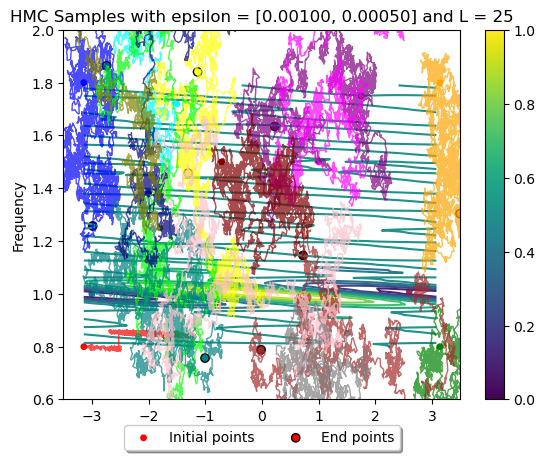

IndexError: list index out of range

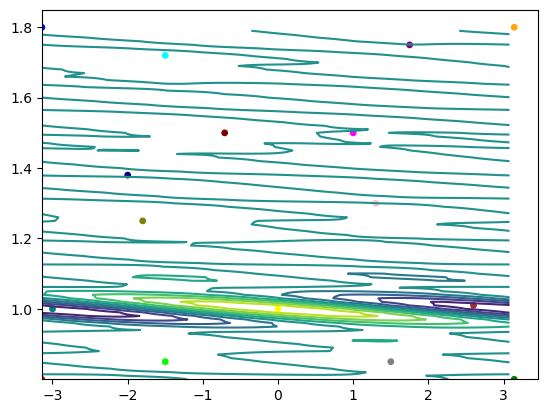

In [33]:
counter = 0
for i in range(len(T)):
    for j in range(len(eps)):
        counter += 1
        plt.contour(phase_t, freq_t, loglike, 10)
        #plt.clabel(visual, inline=True, fontsize=7)
        plt.scatter(x0,y0,c=colors,s=15, marker='o', label='Initial points')
        plt.scatter(sample4[counter-1][9999,:,0], sample4[counter-1][9999,:,1], color=colors, edgecolors='k',marker='o', label='End points')
        for k in range(np.array(sample3).shape[2]):
            plt.plot(sample4[counter-1][:, k, 0], sample4[counter-1][:, k, 1], color=colors[k], alpha=0.7, linewidth=1)
        #plt.plot(sample3[counter-1][:,min:max,0].flatten(), sample3[counter-1][:,min:max,1].flatten(), '.', alpha=0.6)
        plt.xlim([-3.5, 3.5])
        plt.ylim([0.6, 2])
        plt.xlabel('Phase')
        plt.ylabel('Frequency')
        plt.colorbar();
        plt.title('HMC Samples with epsilon = [{:.5f}, {:.5f}] and L = {}'.format(eps[j][0], eps[j][1], T[i]))
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
        plt.show()

counter = 0

for i in range(len(T)):
    for j in range(len(eps)):
        counter += 1

        x = sample4[counter-1][:,:,0].flatten()
        y = sample4[counter-1][:,:,1].flatten()
     
        # Calculate the point density
        xy = np.vstack([x,y])
        kde = gaussian_kde(xy)

        xmin, xmax = x.min(), x.max()
        ymin, ymax = y.min(), y.max()
        X, Y = np.meshgrid(np.linspace(xmin, xmax, 300), np.linspace(ymin, ymax, 300))
        Z = kde(np.vstack([X.ravel(), Y.ravel()])).reshape(X.shape)
        
        # Sort the points by density, so that the densest points are plotted last
        visual = plt.contour(phase_t, freq_t, loglike, 20)
        plt.clabel(visual, inline=True, fontsize=7)
        plt.contourf(X, Y, Z, levels=50, cmap='Blues')
        plt.colorbar(label='Density')
        plt.title('Distribution with path length:{}, step size:{}'.format(T[i],eps[j]))
        plt.xlim([-torch.pi, torch.pi])
        plt.ylim([0.8,1.8])
        plt.show()

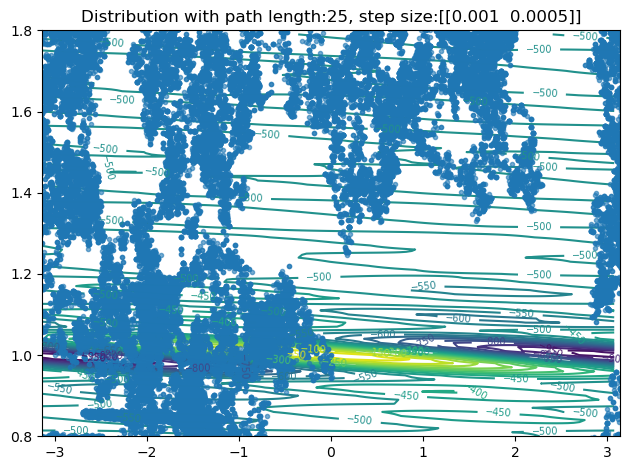

IndexError: list index out of range

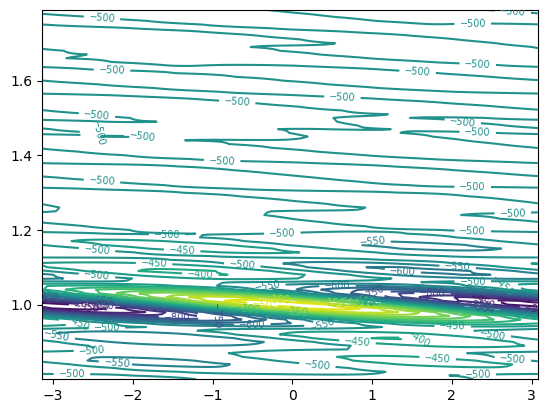

In [31]:
num_sample = 10
counter = 0
for i in range(len(T)):
    for j in range(len(eps)):
        counter += 1
        visual = plt.contour(phase_t, freq_t, loglike, 20)
        plt.clabel(visual, inline=True, fontsize=7)
        plt.plot(sample4[counter-1][:,0:num_sample,0].flatten(), sample4[counter-1][:,0:num_sample,1].flatten(), '.', alpha=0.6)
        plt.xlim([-torch.pi,torch.pi])
        plt.ylim([0.8,1.8])
        plt.title('Distribution with path length:{}, step size:{}'.format(T[i],eps[[j]]))
        plt.tight_layout()
        plt.show()

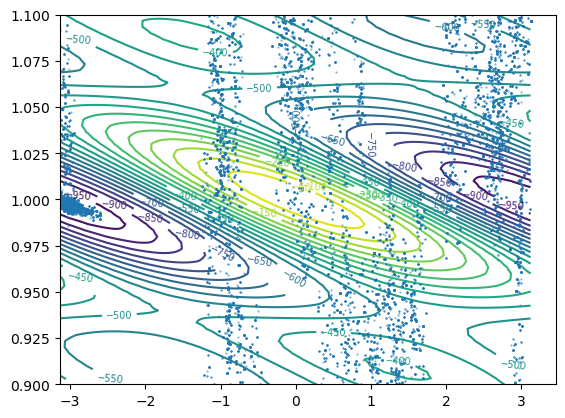

In [66]:
visual = plt.contour(phase_t, freq_t, loglike, 20)
plt.clabel(visual, inline=True, fontsize=7)
plt.plot(sample4[0][:,0:num_sample,0].flatten(), sample4[0][:,0:num_sample,1].flatten(), '.', markersize=1, alpha=0.6)
plt.ylim([0.90,1.10])
plt.show()

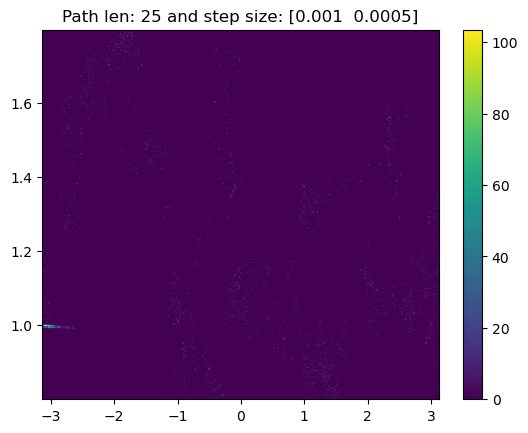

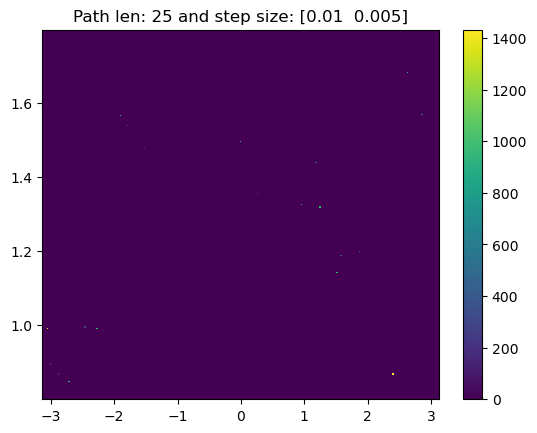

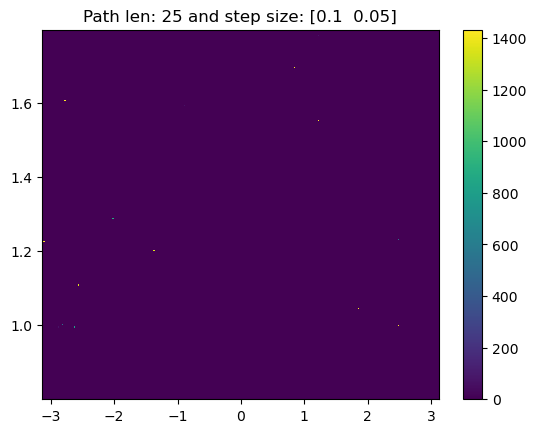

In [67]:
num_sample = 10
counter = 0
for i in range(len(T)):
    for j in range(len(eps)):
        counter += 1
        plt.hist2d(sample4[counter-1][:,0:num_sample,0].flatten(), sample4[counter-1][:,0:num_sample,1].flatten(), bins=[phase_t,freq_t],density=True)
        plt.colorbar();
        plt.title('Path len: {} and step size: {}'.format(T[i], eps[j]))
        plt.show()

### Evaluation Metrics for HMC (neural switched off)

In [68]:
counter = 0
for i in range(len(T)):
    for j in range(len(eps)):
        counter += 1
        for k in range(n_sample):
            per_accept = np.array(accept4[counter-1]*100)
            print('Given parameter path = {}, and eps = {}, {:.2f} % accepted overall, Time taken: {:.3f}s, \nKL Divergence: {:.4f} and ESS for x0: {:.3f}, x1: {:.3f}'
                  .format(T[i], eps[j], np.mean(per_accept), np.array(timetaken4)[counter-1], np.array(kl_divergence4)[counter-1][k], np.array(ess4)[counter-1][0][k][0], np.array(ess4)[counter-1][0][k][1]))

Given parameter path = 25, and eps = [0.001  0.0005], 100.00 % accepted overall, Time taken: 252.834s, 
KL Divergence: 7.7592 and ESS for x0: 27.076, x1: 54.078
Given parameter path = 25, and eps = [0.001  0.0005], 100.00 % accepted overall, Time taken: 252.834s, 
KL Divergence: 5.2893 and ESS for x0: 24.802, x1: 10.533
Given parameter path = 25, and eps = [0.001  0.0005], 100.00 % accepted overall, Time taken: 252.834s, 
KL Divergence: 5.0528 and ESS for x0: 16.361, x1: 7.275
Given parameter path = 25, and eps = [0.001  0.0005], 100.00 % accepted overall, Time taken: 252.834s, 
KL Divergence: 5.2596 and ESS for x0: 22.790, x1: 29.476
Given parameter path = 25, and eps = [0.001  0.0005], 100.00 % accepted overall, Time taken: 252.834s, 
KL Divergence: 5.1775 and ESS for x0: 8.300, x1: 5.741
Given parameter path = 25, and eps = [0.001  0.0005], 100.00 % accepted overall, Time taken: 252.834s, 
KL Divergence: 5.2651 and ESS for x0: 6.631, x1: 6.000
Given parameter path = 25, and eps = [0

In [69]:
np.nanmean(np.array(timetaken4)), np.nanmean(kl_divergence4,axis=1), np.nanmean(ess4,axis=2)

(252.87687357266745,
 array([ 5.46527065, 10.79769058, 11.26172951]),
 array([[[16.99640506, 23.47637954]],
 
        [[11.0772887 , 12.57007255]],
 
        [[19.77907544, 18.77072133]]]))